# New York City Taxi Trip Duration
      - Share code and data to improve ride time predictions 

A반 3조 "데박사건"
* 최정혁
* 심호섭

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

from datetime import datetime

In [1]:
# 경로 변수 (고정)


trainfile = '../_data/train_03_997.csv'
old_trainfile = '../_data/train.csv'
kaggle_trainfile = '../_data/train_k.csv'

testfile = '../_data/test_clean.csv'
old_testfile = '../_data/test.csv'

train_171016 = '../_data/171016_dow_hr_pas_L2_dur_only.csv'
train_osrm = '../_data/train_with_osrm.csv'
train_osrm_weather = '../_data/train_with_osrm_and_weather.csv'
train_osrm_weather_hourly = '../_data/train_with_osrm_and_weather_hourly.csv'
train_dropped_nan_fixed = '../_data/train__dropped__no_disaster_nan_fixed.csv'
train_added_airps = '../_data/train__dropped__lnglat_saved__airports__no_disaster.csv'
train_added_airps_cleaned = '../_data/train__dropped__cleaned__airports__no_disaster.csv'
train_added_airps_disas_cleaned = '../_data/train__dropped__cleaned__eval__airports__disaster.csv'
train_added_weekhr = '../_data/train__dropped__cleaned__eval__a_d_weekhour.csv'
train_added_manh = '../_data/train__dropped__air_bliz_weekhr_manh.csv'
train_all_vars_rough = '../_data/train__all_vars__rough.csv'

train_701778_all_vars = '../_data/train__701778__all_vars.csv'
train_700806_all_vars_cooks_dropped = '../_data/train_700806_dropped_cooks.csv'
train_700789_all_vars_cooks_dropped_circle_filter = '../_data/train_700789_dropped_cooks__circle_filter.csv'
train_700789_all_vars_cdcf_kmeans = '../_data/train_kmeans_30_added.csv'
train_700419_all_vars_cdcf150kmh_km60 = '../_data/train_kmeans_60_added_cooksd_circle_150kmh.csv'

train_700419_all_vars_4d_clust120 = '../_data/train_kmeans_4D_120.csv'
train_700419_all_vars_4d_clust120_speed = '../_data/train_kmeans_4D_120_clustspeed.csv'
train_700419_all_vars_4d_clust120_speed_glob = '../_data/train_kmeans_4D_120_clustspeed_globalized.csv'

train_700419 = '../_data/train_700419_recent.csv'
train_700419 = '../_data/train_700419_recent_2047.csv'
train_697355 = '../_data/train_697355_rsq_0722.csv'
train_697349 = '../_data/train_697349_rsq_0723.csv'
train_697284 = '../_data/train_697284_rsq_0725.csv'
train_697284 = '../_data/train_697284_FINAL.csv'
train_697284 = '../_data/train_697284_FINAL_FINAL.csv'
train_696688 = '../_data/train_696688_rsq_0731.csv'

test_recent = '../_data/test_recent_2048.csv'
test_recent = '../_data/test_recent_10150717.csv'

trains = [train_700419, train_697355, train_697349, train_697284, train_696688]


# Choose data with 697284 rows to model
train_recent = trains[3]



# 1. Feature Check

## pickup, dropoff의 date 확인

In [118]:
df_taxi = pd.read_csv('../_data/train.csv', infer_datetime_format=True, parse_dates=['pickup_datetime'])
df_taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
701773,id3888279,1,2016-01-01 00:01:00,1/1/16 0:05,1,-73.982292,40.751331,-73.991341,40.750340,N,280
701774,id1210365,2,2016-01-01 00:01:00,1/1/16 0:07,5,-73.965279,40.801041,-73.947479,40.815170,N,408
701775,id0924227,1,2016-01-01 00:01:00,1/1/16 0:13,1,-73.970108,40.759800,-73.989357,40.742989,N,736
701776,id0190469,2,2016-01-01 00:00:00,1/1/16 0:14,5,-73.981743,40.719158,-73.938828,40.829182,N,849
701777,id1665586,1,2016-01-01 00:00:00,1/1/16 0:22,1,-73.985085,40.747166,-73.958038,40.717491,N,1294


#### extremes of given data

In [119]:
for col in ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']:
    print(col)
    print(" min = {}".format(np.percentile(df_taxi[col], 0)))
    print(" 0.3 = {}".format(np.percentile(df_taxi[col], 0.3)))
    print("99.7 = {}".format(np.percentile(df_taxi[col], 99.7)))
    print(" max = {}".format(np.percentile(df_taxi[col], 100)))

pickup_longitude
 min = -78.54740143
 0.3 = -74.01612854
99.7 = -73.7767868
 max = -61.33552933
pickup_latitude
 min = 34.35969543
 0.3 = 40.64364624
99.7 = 40.82314810778
 max = 43.48688507
dropoff_longitude
 min = -79.81797791
 0.3 = -74.03314719446999
99.7 = -73.77867883659
 max = -61.33552933
dropoff_latitude
 min = 32.181140899999995
 0.3 = 40.63059613664
99.7 = 40.86598587
 max = 43.67399979
trip_duration
 min = 1.0
 0.3 = 27.0
99.7 = 4481.668999999994
 max = 3526282.0


In [120]:
# Dates
df_taxi['pickup_date'] = df_taxi['pickup_datetime'].dt.date

# day of month 1 to 30/31
df_taxi['pickup_day'] = df_taxi['pickup_datetime'].dt.day
    
#month of year 1 to 12
df_taxi['pickup_month'] = df_taxi['pickup_datetime'].dt.month

#weekday 0 to 6
df_taxi['pickup_weekday'] = df_taxi['pickup_datetime'].dt.weekday

#week of year
df_taxi['pickup_weekofyear'] = df_taxi['pickup_datetime'].dt.weekofyear

#hour of day 0 to 23
df_taxi['pickup_hour'] = df_taxi['pickup_datetime'].dt.hour

#minute of hour
df_taxi['pickup_minute'] = df_taxi['pickup_datetime'].dt.minute

# day of year
df_taxi['pickup_dayofyear'] = df_taxi['pickup_datetime'].dt.dayofyear

In [121]:
#
df_taxi['pickup_dt'] = (df_taxi['pickup_datetime'] - df_taxi['pickup_datetime'].min()).dt.total_seconds()

#1주일을 시간 단위로
df_taxi['pickup_week_hour'] = df_taxi['pickup_weekday'] * 24 + df_taxi['pickup_hour']

### trip_duration / Month 분포

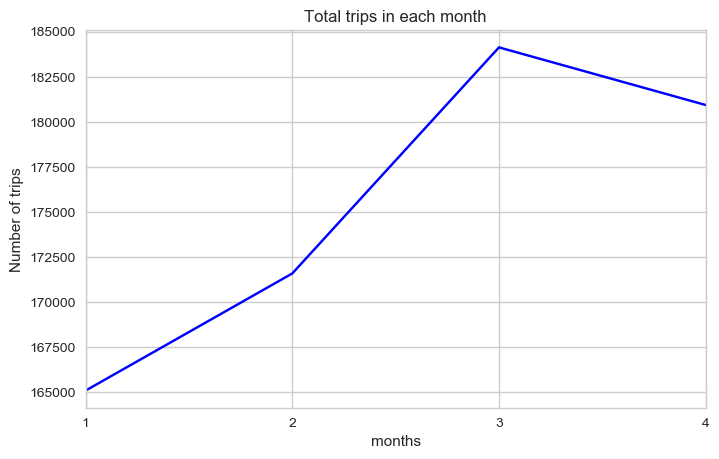

In [122]:
plt.figure(figsize=(8, 5))
df_taxi.pickup_month.value_counts(sort=False).plot(kind='line', color=["blue"])
plt.xticks([1, 2, 3, 4])
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");
plt.show()

### trip_duration / day 분포

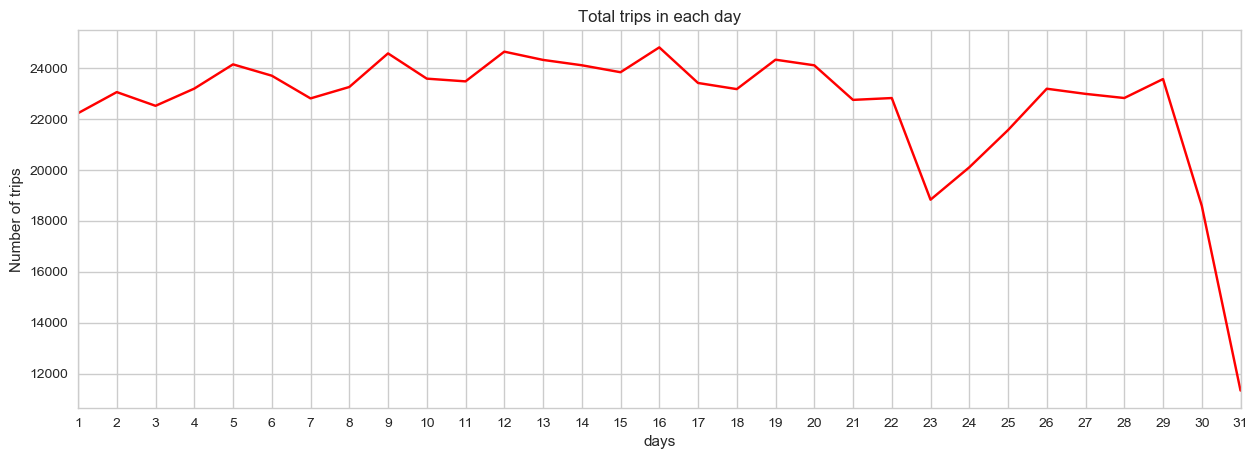

In [124]:
plt.figure(figsize=(15, 5)) 
df_taxi.pickup_day.value_counts(sort=False).plot(kind='line', color=['red'])
plt.xticks(np.arange(1, 32))
plt.xlabel("days")
plt.ylabel("Number of trips")
plt.title("Total trips in each day");
plt.show()

### trip_duration / weekday 분포

In [125]:
df_taxi.pickup_date = pd.to_datetime(df_taxi.pickup_date)

In [126]:
weekday = df_taxi.pickup_date.dt.weekday_name

In [127]:
day_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

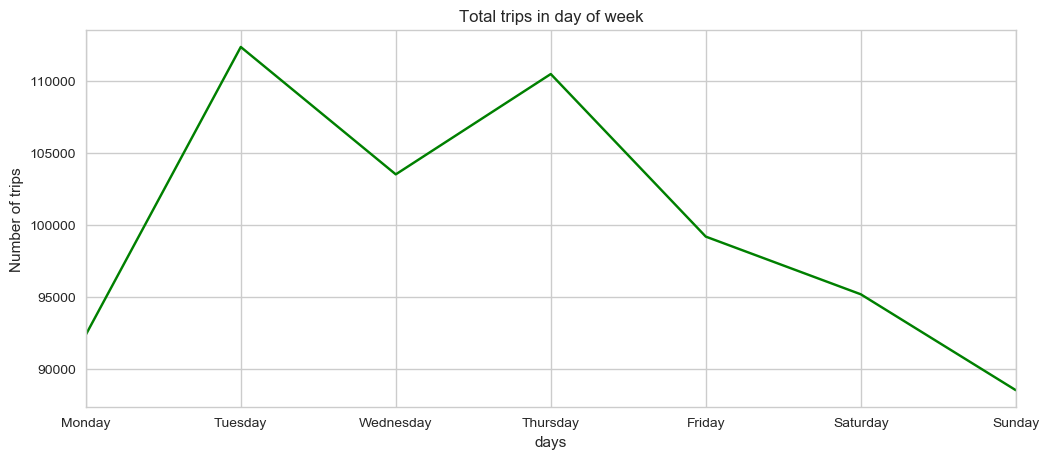

In [128]:
plt.figure(figsize=(12, 5)) 
weekday.value_counts(sort=False).plot(kind='line', color=["green"])
plt.xticks(range(len(day_list)), day_list)
plt.xlabel("days")
plt.ylabel("Number of trips")
plt.title("Total trips in day of week");
plt.show()

### trip_duration / hour 분포

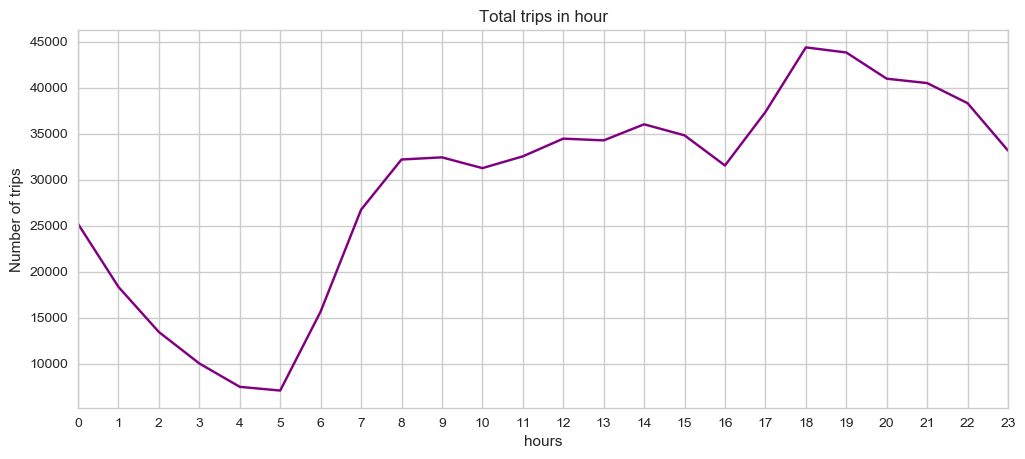

In [129]:
plt.figure(figsize=(12, 5)) 
df_taxi.pickup_hour.value_counts(sort=False).plot(kind='line', color=["purple"])
plt.xticks(np.arange(24))
plt.xlabel("hours")
plt.ylabel("Number of trips")
plt.title("Total trips in hour");
plt.show()

### pickup, dropoff 분포

- 출처 - https://www.kaggle.com/selfishgene/yellow-cabs-tell-the-story-of-new-york-city

In [130]:
df_taxi = pd.read_csv('../_data/train.csv')

# remove obvious outliers
allLat  = np.array(list(df_taxi['pickup_latitude'])  + list(df_taxi['dropoff_latitude']))
allLong = np.array(list(df_taxi['pickup_longitude']) + list(df_taxi['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(df_taxi['trip_duration'], 0.3), np.percentile(df_taxi['trip_duration'], 99.7)]

df_taxi = df_taxi[(df_taxi['pickup_latitude']   >= latLimits[0] ) & (df_taxi['pickup_latitude']   <= latLimits[1]) ]
df_taxi = df_taxi[(df_taxi['dropoff_latitude']  >= latLimits[0] ) & (df_taxi['dropoff_latitude']  <= latLimits[1]) ]
df_taxi = df_taxi[(df_taxi['pickup_longitude']  >= longLimits[0]) & (df_taxi['pickup_longitude']  <= longLimits[1])]
df_taxi = df_taxi[(df_taxi['dropoff_longitude'] >= longLimits[0]) & (df_taxi['dropoff_longitude'] <= longLimits[1])]
df_taxi = df_taxi[(df_taxi['trip_duration']     >= durLimits[0] ) & (df_taxi['trip_duration']     <= durLimits[1]) ]
df_taxi = df_taxi.reset_index(drop=True)

allLat  = np.array(list(df_taxi['pickup_latitude'])  + list(df_taxi['dropoff_latitude']))
allLong = np.array(list(df_taxi['pickup_longitude']) + list(df_taxi['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

df_taxi['duration [min]'] = df_taxi['trip_duration']/60.0
df_taxi['src lat [km]']   = latMultiplier  * (df_taxi['pickup_latitude']   - medianLat)
df_taxi['src long [km]']  = longMultiplier * (df_taxi['pickup_longitude']  - medianLong)
df_taxi['dst lat [km]']   = latMultiplier  * (df_taxi['dropoff_latitude']  - medianLat)
df_taxi['dst long [km]']  = longMultiplier * (df_taxi['dropoff_longitude'] - medianLong)

allLat  = np.array(list(df_taxi['src lat [km]'])  + list(df_taxi['dst lat [km]']))
allLong = np.array(list(df_taxi['src long [km]']) + list(df_taxi['dst long [km]']))

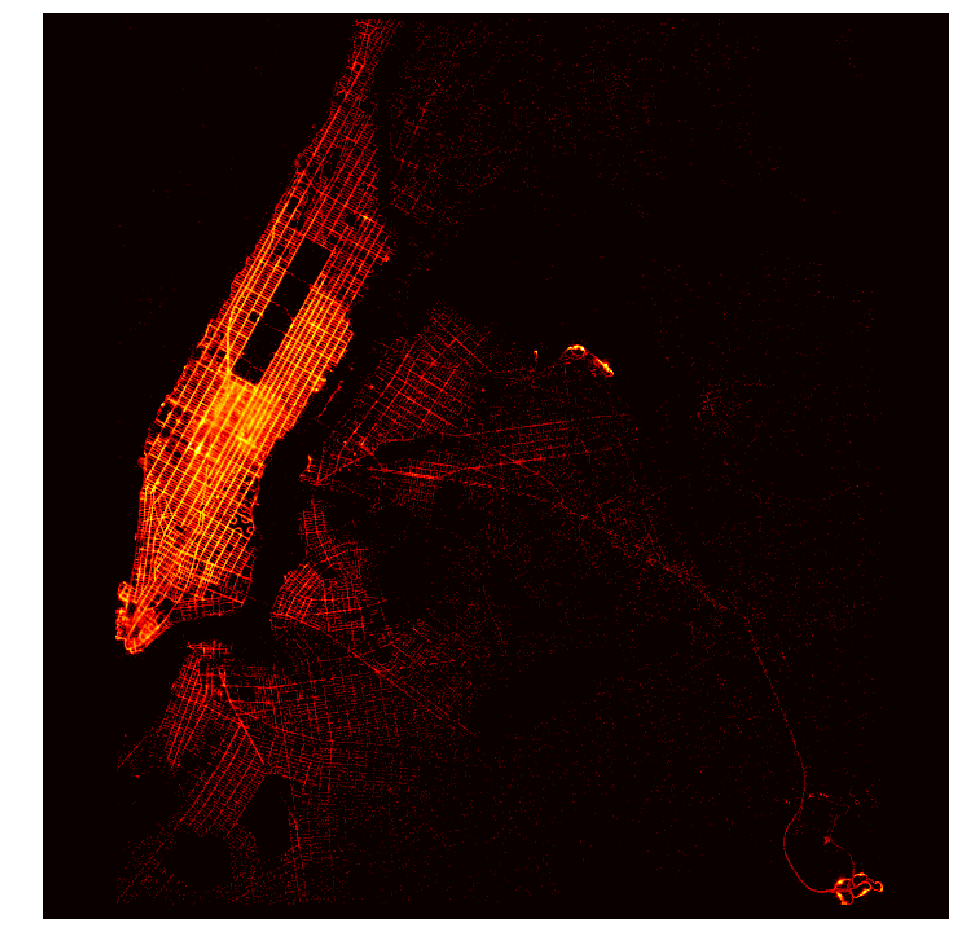

In [131]:
# show the log density of pickup and dropoff locations

imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

plt.show()

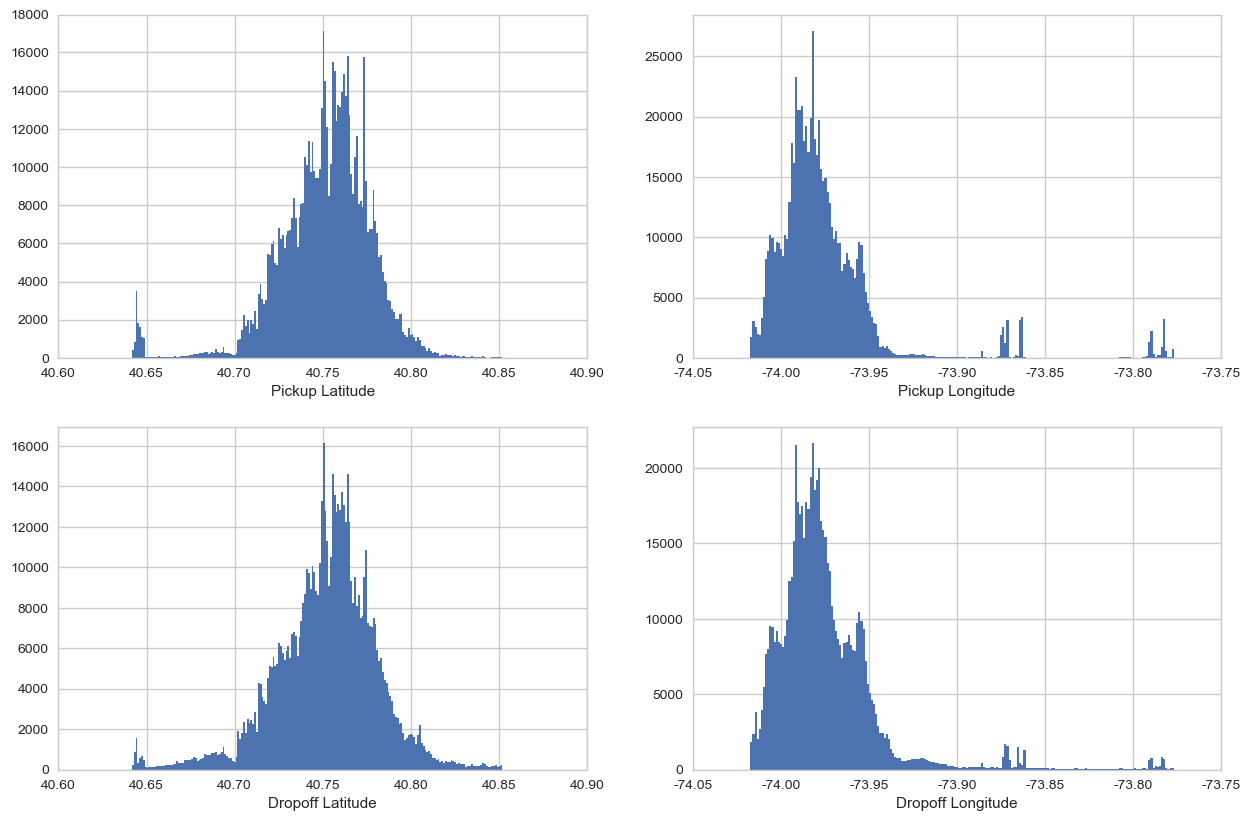

In [31]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), sharex=False, sharey = False)
ax[0,0].hist(df_taxi.pickup_latitude, bins=200)
ax[0,1].hist(df_taxi.pickup_longitude, bins=200)
ax[1,0].hist(df_taxi.dropoff_latitude, bins=200)
ax[1,1].hist(df_taxi.dropoff_longitude, bins=200)
ax[0,0].set_xlabel('Pickup Latitude')
ax[0,0].set_xlim(40.6, 40.9)
ax[0,1].set_xlabel('Pickup Longitude')
ax[0,1].set_xlim(-74.05, -73.75)
ax[1,0].set_xlabel('Dropoff Latitude')
ax[1,0].set_xlim(40.6, 40.9)
ax[1,1].set_xlabel('Dropoff Longitude')
ax[1,1].set_xlim(-74.05, -73.75);
plt.show()

## Trip Duration 분포 check
### * trip_duration vs log(trip_duration)

C:\Users\jchoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


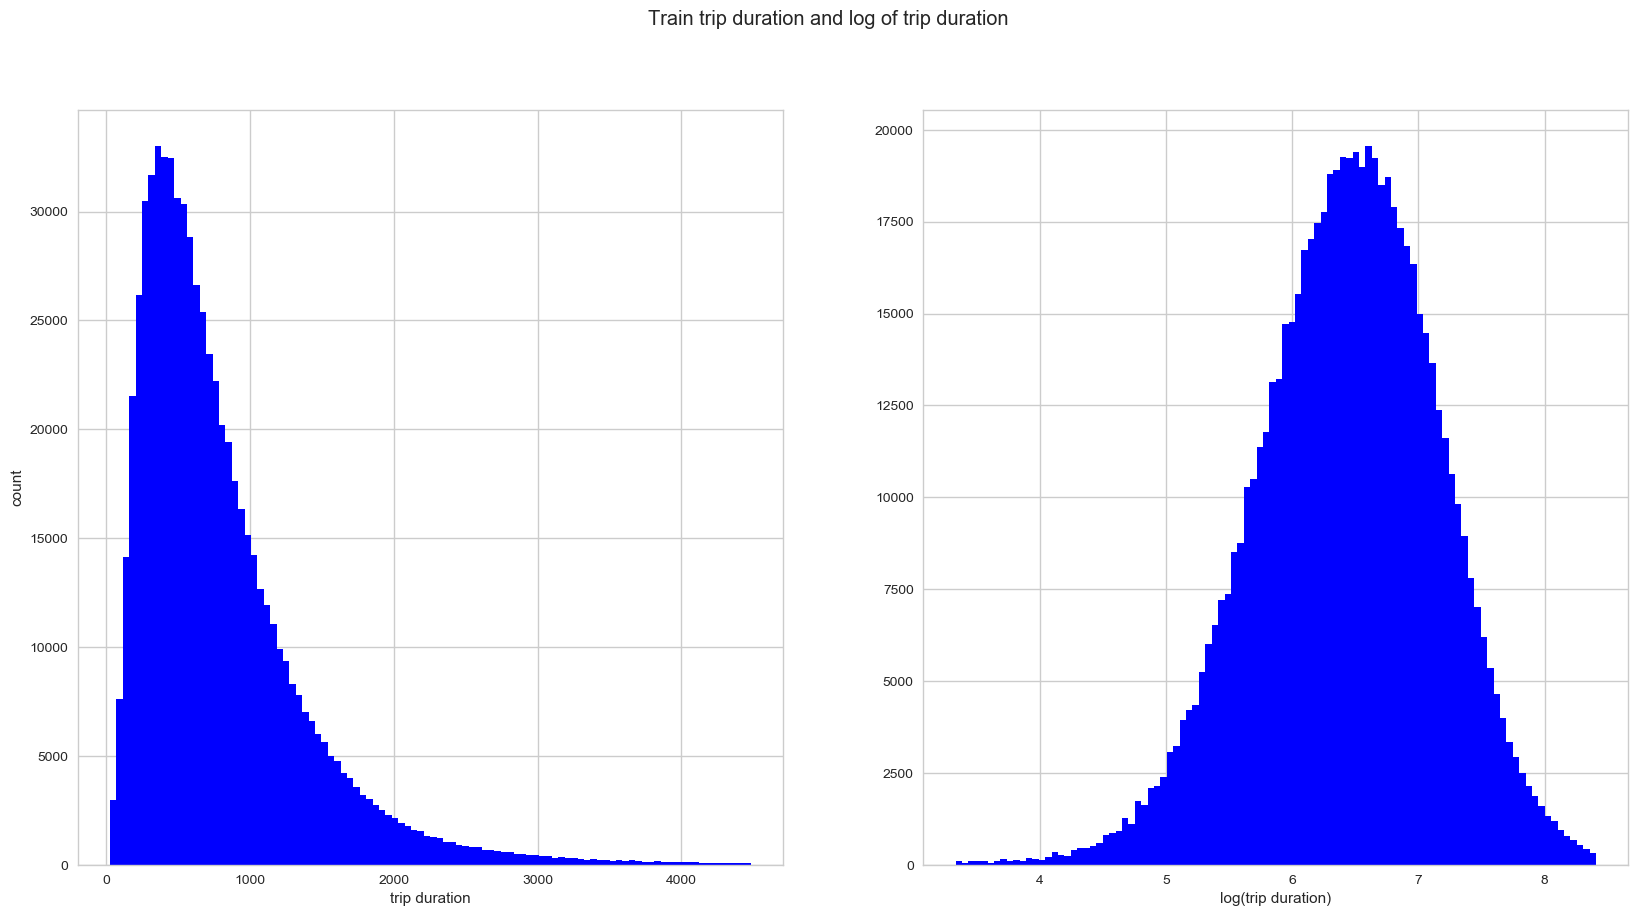

In [133]:
df_taxi['log_trip_duration'] = np.log1p(df_taxi['trip_duration'].values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Train trip duration and log of trip duration')
ax1.legend(loc=0)
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax2.legend(loc=0)
ax1.hist(df_taxi.trip_duration,color='blue', bins=100)
ax2.hist(df_taxi.log_trip_duration,bins=100, color='blue');

plt.show()

# 2. variables 추가

### - 목적지까지의 최단 코스 및 소요 시간, 주말 외 공휴일, 날씨(비, 눈, 온도, 습도, 바람), 구역 분할(도심 및 공항)

<img src="../_data/images/laguardia_map.png" style="width: 500px;" align="left"/> 
<img src="../_data/images/jfk_map.png" style="width: 500px;" align="left"/>

In [2]:
pd.options.display.max_columns = 50

Before processing of columns

In [135]:
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,duration [min],src lat [km],src long [km],dst lat [km],dst long [km],log_trip_duration
0,id3495688,1,4/30/16 23:59,5/1/16 0:24,1,-73.987793,40.724792,-73.975616,40.656445,N,1454,24.233333,-3.315259,-0.570659,-10.923750,0.456141,7.282761
1,id3051282,1,4/30/16 23:59,5/1/16 0:22,1,-73.957596,40.717770,-73.951424,40.775230,N,1409,23.483333,-4.097044,1.975755,2.299492,2.496232,7.251345
2,id0082851,1,4/30/16 23:59,5/1/16 0:17,2,-74.000954,40.742031,-73.947708,40.782200,N,1081,18.016667,-1.396256,-1.680453,3.075331,2.809549,6.986566
3,id0515725,2,4/30/16 23:58,5/1/16 0:12,1,-73.985733,40.738258,-73.993179,40.754890,N,800,13.333333,-1.816237,-0.396952,0.035246,-1.024870,6.685861
4,id1872374,2,4/30/16 23:58,5/1/16 0:17,1,-74.006615,40.740650,-73.985619,40.723362,N,1151,19.183333,-1.549980,-2.157826,-3.474503,-0.387302,7.049255


After processing of columns

Variable candidates:
* is_hol (Is the day a holiday?)
* blizz (Value assigned to account for effect of blizzard)
* m_d (Month + day in integer form)
* dow (weekday string)
* hr (hour in 24hrs format)
* wkhr (weekhour encoded as 0 = Monday 12AM, 167 = Sunday 11PM
* L2 (Raw L2 norm between pickup and dropoff longitude/latitudes)
* pas_cnt (passenger count)
* p_JFK, p_LGA, d_JFK, d_LGA (Boolean indicator of coordinate in airport)
* p_lng, p_lat, d_lng, d_lat (Coordinates)
* total_dist, total_time (OSRM information)
  * Source: https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/data
* day_max_temp, day_min_temp, day_rainfall, day_snowfall, day_snowdepth (Daily weather information)
  * Source: https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016/data
* hr_temp, hr_humid, hr_dewpt, hr_windspeed, hr_gustspeed, hr_precip
  * Source: https://www.kaggle.com/cabaki/knycmetars2016/data
* dur (total duration; target value)

In [136]:
pd.options.display.max_columns = 50

In [3]:
df_train = pd.read_csv('../_data/train__701778__all_vars.csv')

In [4]:
df_train.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [5]:
df_train.shape

(701778, 30)

# circle filter (`701778 -> 701760`)

<img src="../_data/images/nycircle.png" style="width: 500px;"/> 

In [6]:
df_copy = df_train.copy()

In [7]:
center_coords = np.array((-74.002786, 40.728319))  # NYC Washington Square Park
edge_coords = np.array((-75.431274, 39.771776))  # approx. 100 miles away

In [8]:
taxi_radius = np.linalg.norm(center_coords - edge_coords)
taxi_radius

1.7191720324019342

In [9]:
def within_radius(lng, lat):
    return np.linalg.norm(center_coords - np.array([lng, lat])) < taxi_radius

## filter pickup coordinates outside of radius

In [10]:
df_circlep = df_train.loc[np.vectorize(within_radius)(\
                            df_train['p_lng'],
                            df_train['p_lat'])].copy()
df_circlep.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [11]:
df_circlep.shape

(701764, 30)

## filter dropoff coordinates outside of radius

In [12]:
df_circle = df_circlep.loc[np.vectorize(within_radius)(\
                            df_circlep['d_lng'],
                            df_circlep['d_lat'])].copy()
df_circle.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [13]:
df_circle.shape

(701760, 30)

In [14]:
df_circle.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


## resulting extremes

In [15]:
for col in ['p_lng', 'p_lat', 'd_lng', 'd_lat']:
    print(col)
    print(" min = {}".format(np.percentile(df_circle[col], 0)))
    print(" 0.3 = {}".format(np.percentile(df_circle[col], 0.3)))
    print("99.7 = {}".format(np.percentile(df_circle[col], 99.7)))
    print(" max = {}".format(np.percentile(df_circle[col], 100)))

p_lng
 min = -75.24149323
 0.3 = -74.01612854
99.7 = -73.7767868
 max = -73.22267914
p_lat
 min = 40.22580338
 0.3 = 40.64365005
99.7 = 40.82313707649
 max = 41.69679642
d_lng
 min = -75.57015228
 0.3 = -74.03293573416
99.7 = -73.77871152351
 max = -72.67115021
d_lat
 min = 40.22579956
 0.3 = 40.63078138351
99.7 = 40.86590746649
 max = 41.69335175


# Fox criterion filter (`701760 -> 700789`)

In [16]:
df_copy = df_circle.copy()

Preliminary OLS using rudimentary guess

In [18]:
from datetime import datetime
t0 = datetime.now()
mod = sm.OLS.from_formula('np.log(I(dur + 1)) ~ C(is_hol)\
                               + C(dow):C(hr)\
                               + scale(np.log(total_dist+1)) - 1', data=df_copy)
res = mod.fit()
print('done')
t1 = datetime.now()

print("{} sec".format((t1 - t0).seconds))

done
29 sec


In [19]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(I(dur + 1))   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     5566.
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        20:43:18   Log-Likelihood:            -5.2852e+05
No. Observations:              701760   AIC:                         1.057e+06
Df Residuals:                  701590   BIC:                         1.059e+06
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
C(is_hol)[False]                  6.3191      0.008    799.017      0.000       6.304       6.335
C(is_hol)[True]                   6.1740      0.009    698.451      0.000       6.157       6.191
C(hr)[T.1]                       -0.0360      0.012     -2.884      0.004      -0.060      -0.012
C(hr)[T.2]                       -0.0887      0.014     -6.358      0.000      -0.116      -0.061
C(hr)[T.3]                       -0.0894      0.015     -5.798      0.000      -0.120      -0.059
C(hr)[T.4]                       -0.1196      0.017     -6.983      0.000      -0.153      -0.086
C(hr)[T.5]                       -0.2361      0.017    -14.032      0.000      -0.269      -0.203
C(hr)[T.6]                       -0.1957      0.013    -15.507      0.000      -0.220      -0.171
C(hr)[T.7]                        0.0418      0.011      3.871      0.000       0.021       0.063
C(hr)[T.8]                        0.2429      0.010     23.148      0.000       0.222       0.263
C(hr)[T.9]                        0.2864      0.011     26.958      0.000       0.266       0.307
C(hr)[T.10]                       0.2907      0.011     26.628      0.000       0.269       0.312
C(hr)[T.11]                       0.2978      0.011     27.451      0.000       0.277       0.319
C(hr)[T.12]                       0.2825      0.011     26.430      0.000       0.262       0.303
C(hr)[T.13]                       0.2305      0.011     21.574      0.000       0.210       0.251
C(hr)[T.14]                       0.2692      0.010     25.665      0.000       0.249       0.290
C(hr)[T.15]                       0.3085      0.011     28.992      0.000       0.288       0.329
C(hr)[T.16]                       0.2522      0.011     22.964      0.000       0.231       0.274
C(hr)[T.17]                       0.2336      0.010     22.342      0.000       0.213       0.254
C(hr)[T.18]                       0.2328      0.010     23.230      0.000       0.213       0.252
C(hr)[T.19]                       0.1947      0.010     19.577      0.000       0.175       0.214
C(hr)[T.20]                       0.1390      0.010     13.727      0.000       0.119       0.159
C(hr)[T.21]                       0.1231      0.010     12.094      0.000       0.103       0.143
C(hr)[T.22]                       0.1474      0.010     14.592      0.000       0.128       0.167
C(hr)[T.23]                       0.1490      0.010     14.714      0.000       0.129       0.169
C(dow)[T.Monday]:C(hr)[0]        -0.1654      0.014    -11.882      0.000      -0.193      -0.138
C(dow)[T.Saturday]:C(hr)[0]       0.0781      0.010      7.560      0.000       0.058       0.098
C(dow)[T.Sunday]:C(hr)[0]         0.0665      0.010      6.397      0.000       0.046       0.087
C(dow)[T.Thursday]:C(hr)[0]      -0.0972     

In [20]:
df_dropped = pd.DataFrame(columns=df_copy.columns)
df_dropped

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur


In [21]:
# dropping outliers by fox_criteria
# original author: 조성빈
def dropping_outliers1(fmla, data):
    model = sm.OLS.from_formula(fmla, data)
    result = model.fit()
    influence = result.get_influence()
    cooks_d2, pvals = influence.cooks_distance
    fox_cr = 4 / (result.df_resid -1)
    print("Fox criterion for Cook's distance:", fox_cr)
    idx = np.where(cooks_d2 > fox_cr)[0]
    df_dropped = data.loc[idx].copy()
    data = data.drop(data.index[idx])
    print("Function dropping_outliers:        " + str(len(idx)) + ' rows have been deleted')
    return data, df_dropped

In [156]:
df_copy.shape

(701760, 30)

In [22]:
from datetime import datetime

t0 = datetime.now()
fmla = 'dur ~ C(is_hol) + C(dow):C(hr) + scale(total_dist) - 1'

df_copy2, df_dropped = dropping_outliers1(fmla, df_copy)

t1 = datetime.now()

print(t1 - t0)

df_copy2.head()

Fox criterion for Cook's distance: 5.70134366417e-06
Function dropping_outliers:        971 rows have been deleted
0:00:30.500619


,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


## dropped rows
* high duration

In [23]:
df_dropped.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
55,False,0,430,Saturday,23,143,0.020996,1,False,False,False,False,-74.005669,40.745209,-73.989098,40.758102,2512.4,309.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,86073
405,False,0,430,Saturday,22,142,0.010217,2,False,False,False,False,-73.976662,40.747765,-73.967712,40.752693,1265.4,135.2,65,46,0.0,0.0,0.0,11.1,0.53,1.7,5.6,0.0,0.0,86323
991,False,0,430,Saturday,21,141,0.014269,1,False,False,False,False,-73.991150,40.750629,-73.987946,40.736725,1889.9,265.7,65,46,0.0,0.0,0.0,11.7,0.47,0.6,11.1,0.0,0.0,86356
2617,False,0,430,Saturday,16,136,0.180187,1,True,False,False,False,-73.782318,40.644741,-73.944893,40.722439,20929.1,1333.6,65,46,0.0,0.0,0.0,16.7,0.34,0.6,11.1,0.0,0.0,26722
3201,False,0,430,Saturday,14,134,0.027076,5,False,False,False,False,-73.990387,40.737202,-74.012169,40.721119,3387.8,420.1,65,46,0.0,0.0,0.0,16.7,0.38,2.2,13.0,0.0,0.0,86317


In [24]:
top_5 = df_copy2['dur'].sort_values(ascending=False).head().index

## remaining rows
* not ideal, but workable

In [25]:
df_copy2.loc[top_5, 'dur']

342274    18439
234110    15418
609652    14243
78734     14160
533186    13850
Name: dur, dtype: int64

In [26]:
df_dropped['dur'].sort_values(ascending=False).head()

991      86356
405      86323
3201     86317
15689    86299
13157    86245
Name: dur, dtype: int64

In [27]:
df_copy2.shape

(700789, 30)

Update

In [28]:
df_copy = df_copy2.copy()

#### OLS results after Fox filter

In [32]:
fmla = 'np.log(I(dur + 1)) ~ C(is_hol)\
+ C(dow):C(hr)\
+ scale(np.log(total_dist+1)) - 1'
fmla

'np.log(I(dur + 1)) ~ C(is_hol)+ C(dow):C(hr)+ scale(np.log(total_dist+1)) - 1'

In [33]:
t0 = datetime.now()
modelz = sm.OLS.from_formula(fmla, df_copy2)
resz = modelz.fit()
print('done')
t1 = datetime.now()
print(t1-t0)

done
0:00:29.403686


In [34]:
resz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(I(dur + 1))   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     6338.
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        20:46:17   Log-Likelihood:            -4.8196e+05
No. Observations:              700789   AIC:                         9.643e+05
Df Residuals:                  700619   BIC:                         9.662e+05
Df Model:                         169                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
C(is_hol)[False]                  6.3071      0.007    850.387      0.000       6.293       6.322
C(is_hol)[True]                   6.1604      0.008    743.184      0.000       6.144       6.177
C(hr)[T.1]                       -0.0306      0.012     -2.615      0.009      -0.054      -0.008
C(hr)[T.2]                       -0.0840      0.013     -6.418      0.000      -0.110      -0.058
C(hr)[T.3]                       -0.0965      0.014     -6.671      0.000      -0.125      -0.068
C(hr)[T.4]                       -0.1249      0.016     -7.770      0.000      -0.156      -0.093
C(hr)[T.5]                       -0.2338      0.016    -14.820      0.000      -0.265      -0.203
C(hr)[T.6]                       -0.1856      0.012    -15.686      0.000      -0.209      -0.162
C(hr)[T.7]                        0.0477      0.010      4.710      0.000       0.028       0.068
C(hr)[T.8]                        0.2485      0.010     25.259      0.000       0.229       0.268
C(hr)[T.9]                        0.2909      0.010     29.209      0.000       0.271       0.310
C(hr)[T.10]                       0.2971      0.010     29.030      0.000       0.277       0.317
C(hr)[T.11]                       0.3050      0.010     29.992      0.000       0.285       0.325
C(hr)[T.12]                       0.2877      0.010     28.701      0.000       0.268       0.307
C(hr)[T.13]                       0.2346      0.010     23.413      0.000       0.215       0.254
C(hr)[T.14]                       0.2747      0.010     27.934      0.000       0.255       0.294
C(hr)[T.15]                       0.3059      0.010     30.648      0.000       0.286       0.325
C(hr)[T.16]                       0.2576      0.010     25.017      0.000       0.237       0.278
C(hr)[T.17]                       0.2406      0.010     24.546      0.000       0.221       0.260
C(hr)[T.18]                       0.2382      0.009     25.351      0.000       0.220       0.257
C(hr)[T.19]                       0.2006      0.009     21.516      0.000       0.182       0.219
C(hr)[T.20]                       0.1439      0.009     15.160      0.000       0.125       0.163
C(hr)[T.21]                       0.1290      0.010     13.515      0.000       0.110       0.148
C(hr)[T.22]                       0.1536      0.009     16.218      0.000       0.135       0.172
C(hr)[T.23]                       0.1491      0.009     15.701      0.000       0.130       0.168
C(dow)[T.Monday]:C(hr)[0]        -0.1612      0.013    -12.352      0.000      -0.187      -0.136
C(dow)[T.Saturday]:C(hr)[0]       0.0828      0.010      8.548      0.000       0.064       0.102
C(dow)[T.Sunday]:C(hr)[0]         0.0734      0.010      7.534      0.000       0.054       0.093
C(dow)[T.Thursday]:C(hr)[0]      -0.0908     

# average speed filter (150km/h) `700789 -> 700419`

In [35]:
df_copy.insert(17, 'avg_spd', 3.6*df_copy['total_dist'] / df_copy['dur'])
df_copy.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,avg_spd,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,24.786272,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,26.462172,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,30.890731,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,12.271050,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,10.808758,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [167]:
df_copy.loc[df_copy['avg_spd'] > 150, 'avg_spd'].shape

(370,)

In [168]:
df_copy.loc[df_copy['avg_spd'] > 150, 'avg_spd'].index

Int64Index([  2820,   9603,  12063,  12486,  15405,  16299,  19217,  21857,
             22591,  23861,
            ...
            682556, 684886, 686714, 693314, 693708, 694426, 694563, 695946,
            701288, 701544],
           dtype='int64', length=370)

In [169]:
df_copy.drop(df_copy.loc[df_copy['avg_spd'] > 150, 'avg_spd'].index, inplace=True)

In [170]:
df_copy.head()

,is_hol,blizz,m_d,dow,hr,wkhr,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,avg_spd,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,False,0,430,Saturday,23,143,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,24.786272,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,False,0,430,Saturday,23,143,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,26.462172,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,False,0,430,Saturday,23,143,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,30.890731,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,False,0,430,Saturday,23,143,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,12.271050,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,False,0,430,Saturday,23,143,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,10.808758,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [171]:
df_copy.shape

(700419, 31)

# Addition of feature: `clust_spd`

In [172]:
# train_with_osrm_and_weather.csv
df_train = pd.read_csv('../_data/pres_pre_clustspd_clust_train.csv')
df_train.head()

,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,430,Saturday,23,19,59,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,0.0,False,430,Saturday,23,11,0,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,0.0,False,430,Saturday,23,38,63,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,0.0,False,430,Saturday,23,35,55,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,0.0,False,430,Saturday,23,14,79,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [173]:
df_train.shape

(700419, 29)

In [174]:
df_copy = df_train.copy()

## KMeans (n=80) pickup / train AND test

In [175]:
pickup_coords = df_copy[['p_lat', 'p_lng']].copy()

# Warning: 10분 걸림

In [19]:
# from sklearn.cluster import KMeans
# from datetime import datetime

# t0 = datetime.now()
# print(t0)

# pickup_coords = df_copy[['p_lat', 'p_lng']].copy()
# kmeans = KMeans(n_clusters=80)

# kmeans.fit(pickup_coords)

# y_kmeans = kmeans.predict(pickup_coords)

# t1 = datetime.now()

# print(t1-t0)

2017-10-24 19:24:46.587571
0:10:42.739679


# ===== 오래 걸리는 코드 대신 미리 계산한 클러스터 벡터 사용 =====

In [176]:
df_traincl = pd.read_csv('../_data/pres_train_clust.csv',\
                       usecols=['p_clust', 'd_clust', 'p_lng', 'p_lat', 'd_lng', 'd_lat'])
df_traincl.head()

,p_clust,d_clust,p_lng,p_lat,d_lng,d_lat
0,19,59,-73.987793,40.724792,-73.975616,40.656445
1,11,0,-73.957596,40.717770,-73.951424,40.775230
2,38,63,-74.000954,40.742031,-73.947708,40.782200
3,35,55,-73.985733,40.738258,-73.993179,40.754890
4,14,79,-74.006615,40.740650,-73.985619,40.723362


In [177]:
df_testcl = pd.read_csv('../_data/pres_test_clust.csv',\
                       usecols=['p_clust', 'd_clust', 'p_lng', 'p_lat', 'd_lng', 'd_lat'])
df_testcl.head()

,p_clust,d_clust,p_lng,p_lat,d_lng,d_lat
0,58,45,-73.998291,40.722618,-73.971779,40.762470
1,22,6,-73.955109,40.689564,-73.978203,40.685802
2,36,6,-73.978416,40.791576,-73.973160,40.675968
3,3,31,-73.873093,40.774097,-73.926704,40.856739
4,53,56,-73.979416,40.755211,-74.003548,40.738224


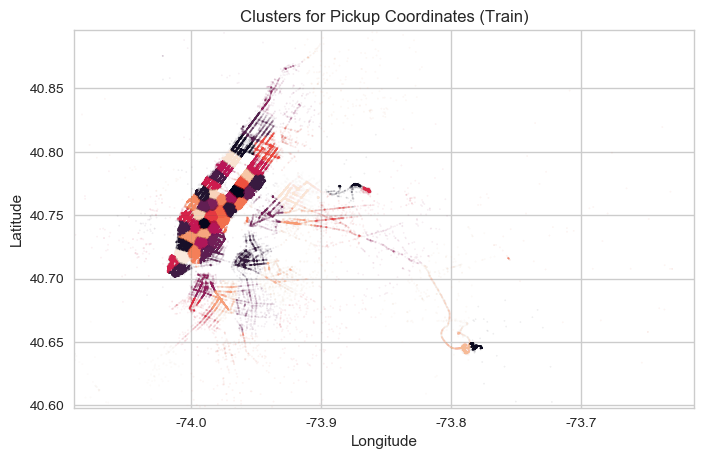

0:00:18.565491


In [178]:
t0 = datetime.now()


plt.scatter(df_traincl.iloc[:, 2], df_traincl.iloc[:, 3],\
            c=df_traincl.iloc[:, 0], s=1, alpha=0.05)

plt.xlim(-74.090, -73.613)
plt.ylim(40.598, 40.896)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters for Pickup Coordinates (Train)')

plt.show()


t1 = datetime.now()
print(t1-t0)

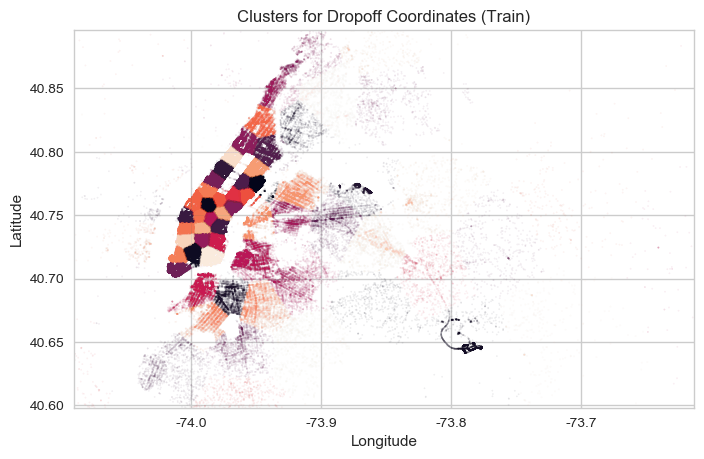

0:00:17.684035


In [179]:
t0 = datetime.now()


plt.scatter(df_traincl.iloc[:, 4], df_traincl.iloc[:, 5],\
            c=df_traincl.iloc[:, 1], s=1, alpha=0.05)

plt.xlim(-74.090, -73.613)
plt.ylim(40.598, 40.896)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters for Dropoff Coordinates (Train)')

plt.show()


t1 = datetime.now()
print(t1-t0)

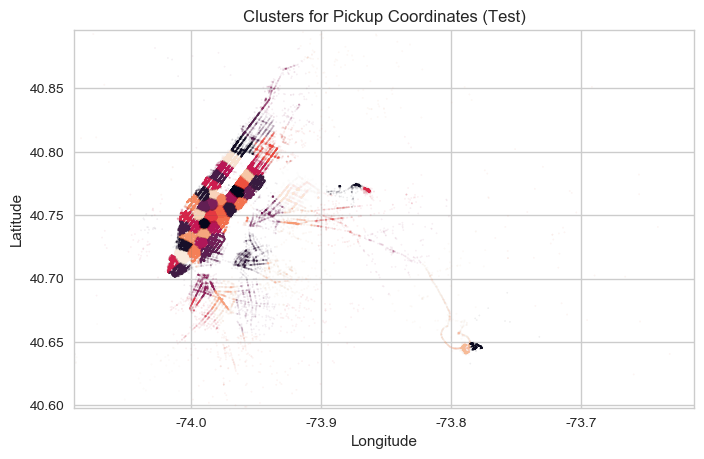

0:00:08.682063


In [180]:
t0 = datetime.now()


plt.scatter(df_testcl.iloc[:, 2], df_testcl.iloc[:, 3],\
            c=df_testcl.iloc[:, 0], s=1, alpha=0.05)

plt.xlim(-74.090, -73.613)
plt.ylim(40.598, 40.896)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters for Pickup Coordinates (Test)')

plt.show()


t1 = datetime.now()
print(t1-t0)

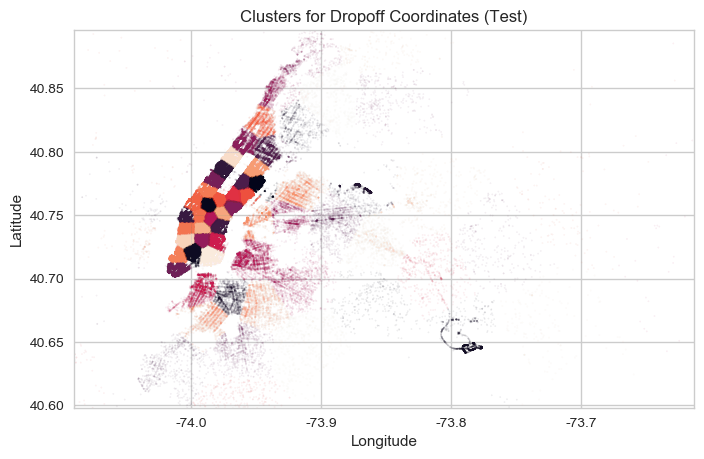

0:00:08.714172


In [181]:
t0 = datetime.now()


plt.scatter(df_testcl.iloc[:, 4], df_testcl.iloc[:, 5],\
            c=df_testcl.iloc[:, 1], s=1, alpha=0.05)

plt.xlim(-74.090, -73.613)
plt.ylim(40.598, 40.896)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters for Dropoff Coordinates (Test)')

plt.show()


t1 = datetime.now()
print(t1-t0)

## KMeans (n=80) dropoff train AND test

In [182]:
dropoff_coords = df_copy[['d_lat', 'd_lng']].copy()

# Warning: 15분 걸림

In [116]:
# from sklearn.cluster import KMeans
# from datetime import datetime

# t0 = datetime.now()
# print(t0)

# dropoff_coords = df_copy[['d_lat', 'd_lng']].copy()
# kmeans = KMeans(n_clusters=80)

# kmeans.fit(dropoff_coords)

# y_kmeans = kmeans.predict(dropoff_coords)

# t1 = datetime.now()

# print(t1-t0)

# y_kmeans[:5]

# clust-pair speed with sparse clust replaced by global avg

In [183]:
df_train2 = pd.read_csv('../_data/pres_pre_clustspd_clust_train.csv')

df_test2 = pd.read_csv('../_data/pres_pre_clustspd_clust_test.csv')

In [184]:
df_train2.head()

,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,430,Saturday,23,19,59,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,0.0,False,430,Saturday,23,11,0,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,0.0,False,430,Saturday,23,38,63,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,0.0,False,430,Saturday,23,35,55,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,0.0,False,430,Saturday,23,14,79,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [185]:
df_test2.head()

,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,630,Thursday,23,58,45,False,False,False,False,-73.998291,40.722618,-73.971779,40.762470,5280.3,623.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
1,0.0,False,630,Thursday,23,22,6,False,False,False,False,-73.955109,40.689564,-73.978203,40.685802,2573.5,219.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
2,0.0,False,630,Thursday,23,36,6,False,False,False,False,-73.978416,40.791576,-73.973160,40.675968,15048.8,1300.0,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
3,0.0,False,630,Thursday,23,3,31,False,True,False,False,-73.873093,40.774097,-73.926704,40.856739,16818.3,1029.1,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
4,0.0,False,630,Thursday,23,53,56,False,False,False,False,-73.979416,40.755211,-74.003548,40.738224,3536.7,434.5,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN


In [186]:
df_test2.shape, df_train2.shape

((346797, 29), (700419, 29))

In [187]:
df_both = df_train2.append(df_test2)
df_both.reset_index(inplace=True)

In [190]:
global_avgspd = df_train['total_dist'].sum() / df_train['dur'].sum() * 3.6
global_avgspd # 20.22488

20.22488025273985

In [189]:
gby_clustspd = df_both.groupby(['p_clust', 'd_clust'])
gby_clustspd.groups[(0, 0)]

Int64Index([    325,    1509,    1528,    1622,    1668,    2681,    2961,
               3160,    3405,    3654,
            ...
            1039779, 1039793, 1039945, 1040056, 1041341, 1042750, 1043778,
            1043940, 1045029, 1047086],
           dtype='int64', length=1456)

In [191]:
df_both.iloc[gby_clustspd.groups[(61, 62)], :].tail(20)

,index,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
369439,369439,0.0,False,229,Monday,2,61,62,False,False,False,False,-73.867195,40.845058,-73.912888,40.766499,11906.2,803.8,61,47,0.05,0.0,0.0,10.6,0.46,-0.6,14.8,29.6,0.0,698.0


In [193]:
pd.options.display.max_columns = 60
df_train0 = pd.read_csv('../_data/pres_700419_extreme.csv')
df_train0.head()

,didnt_move,is_hol,blizz,m_d,dow,hr,wkhr,p_clust,d_clust,clust_spd,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,avg_spd,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,0,430,Saturday,23,143,19,59,22.972353,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,24.786272,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,0.0,False,0,430,Saturday,23,143,11,0,28.539090,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,26.462172,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,0.0,False,0,430,Saturday,23,143,38,63,25.137761,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,30.890731,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,0.0,False,0,430,Saturday,23,143,35,55,11.904820,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,12.271050,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,0.0,False,0,430,Saturday,23,143,14,79,13.197395,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,10.808758,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [194]:
gby_train = df_train0.groupby(['p_clust', 'd_clust'])
gby_train.indices.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 12), (0, 13), (0, 15), (0, 16), (0, 17), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 26), (0, 27), (0, 28), (0, 29), (0, 31), (0, 32), (0, 34), (0, 35), (0, 36), (0, 39), (0, 40), (0, 43), (0, 45), (0, 46), (0, 47), (0, 49), (0, 50), (0, 51), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 65), (0, 66), (0, 67), (0, 68), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 79), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 12), (1, 13), (1, 15), (1, 16), (1, 17), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 26), (1, 27), (1, 28), (1, 29), (1, 31), (1, 32), (1, 34), (1, 35), (1, 36), (1, 39), (1, 40), (1, 43), (1, 45), (1, 46), (1, 47), (1, 49), (1, 50), (1, 51), (1, 52), (1, 53), (1, 54), (1, 55), (1, 56), (1, 57), (1, 58), (1, 59), (1, 60), (1, 61), (1, 62), (1, 63), 

In [195]:
global_avgspd = df_train0['total_dist'].sum() / df_train0['dur'].sum() * 3.6
global_avgspd

20.22488025273985

In [196]:
clust_spd = pd.Series(np.zeros(df_both.shape[0]), name='clust_spd')
for idx in gby_train.indices.keys():
    clust_spd[gby_clustspd.groups[idx]]\
    = df_train0.loc[gby_train.groups[idx], 'avg_spd'].mean()

try:
    df_both.insert(8, 'clust_spd', clust_spd)
except:
    pass

In [197]:
col = 'clust_spd'
df_both.loc[df_both[col].value_counts()[df_both[col]].values < 30, col] = global_avgspd

In [198]:
df_both[(20.224879 < df_both['clust_spd']) & (df_both['clust_spd'] < 20.224881)]

,index,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
50,50,0.0,False,430,Saturday,23,55,75,20.22488,False,False,False,False,-73.980759,40.744995,-73.918022,40.663898,16782.2,1165.0,65,46,0.00,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,2330.0
88,88,0.0,False,430,Saturday,23,53,9,20.22488,False,False,False,False,-73.973289,40.752125,-73.759438,40.932163,31741.5,1724.1,65,46,0.00,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,2459.0
234,234,0.0,False,430,Saturday,23,77,59,20.22488,False,False,False,False,-73.969765,40.797577,-73.976982,40.672497,20567.1,1331.6,65,46,0.00,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,2728.0
268,268,0.0,False,430,Saturday,23,36,43,20.22488,False,False,False,False,-73.975677,40.787312,-73.817123,40.710693,20238.1,1436.9,65,46,0.00,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,3548.0
347,347,0.0,False,430,Saturday,23,40,19,20.22488,False,False,False,False,-73.982643,40.771992,-73.877106,40.743824,10639.3,801.5,65,46,0.00,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1855.0
529,529,0.0,False,430,Saturday,22,24,76,20.22488,False,False,False,False,-73.952499,40.747593,-73.966362,40.797344,10640.3,784.5,65,46,0.00,0.0,0.0,11.1,0.53,1.7,5.6,0.0,0.0,1448.0
664,664,0.0,False,430,Saturday,22,79,73,20.22488,False,False,False,False,-74.001892,40.715389,-73.860092,40.726700,14771.6,1124.9,65,46,0.00,0.0,0.0,11.1,0.53,1.7,5.6,0.0,0.0,2263.0
750,750,0.0,False,430,Saturday,21,67,16,20.22488,False,False,False,False,-73.800934,40.669689,-73.963882,40.774532,24477.1,1408.4,65,46,0.00,0.0,0.0,11.7,0.47,0.6,11.1,0.0,0.0,1867.0
783,783,0.0,False,430,Saturday,21,7,23,20.22488,False,False,False,False,-73.991585,40.764656,-73.843765,40.852249,21922.2,1097.8,65,46,0.00,0.0,0.0,11.7,0.47,0.6,11.1,0.0,0.0,2387.0
801,801,0.0,False,430,Saturday,21,11,45,20.22488,False,False,False,False,-73.957909,40.713867,-73.969337,40.763882,9249.6,646.0,65,46,0.00,0.0,0.0,11.7,0.47,0.6,11.1,0.0,0.0,1339.0


In [199]:
gby_clustspd.size().sort_values().shape

(3810,)

### `clust_spd` feature 완성

In [200]:
df_both.head()

,index,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0,0.0,False,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454.0
1,1,0.0,False,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409.0
2,2,0.0,False,430,Saturday,23,38,63,25.137761,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081.0
3,3,0.0,False,430,Saturday,23,35,55,11.904820,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800.0
4,4,0.0,False,430,Saturday,23,14,79,13.197395,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151.0


## re-divide combined train-test df
n(train) = 700419
n(test) = 3

In [201]:
df_trainz = df_both.loc[:700419, :].copy()
df_trainz.head()

,index,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0,0.0,False,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454.0
1,1,0.0,False,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409.0
2,2,0.0,False,430,Saturday,23,38,63,25.137761,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081.0
3,3,0.0,False,430,Saturday,23,35,55,11.904820,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800.0
4,4,0.0,False,430,Saturday,23,14,79,13.197395,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151.0


In [202]:
del df_trainz['index']

In [203]:
df_trainz.head()

,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454.0
1,0.0,False,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409.0
2,0.0,False,430,Saturday,23,38,63,25.137761,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081.0
3,0.0,False,430,Saturday,23,35,55,11.904820,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800.0
4,0.0,False,430,Saturday,23,14,79,13.197395,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151.0


In [204]:
df_testz = df_both.loc[700419:, :].copy()
df_testz.head()

,index,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
700419,0,0.0,False,630,Thursday,23,58,45,17.343755,False,False,False,False,-73.998291,40.722618,-73.971779,40.762470,5280.3,623.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
700420,1,0.0,False,630,Thursday,23,22,6,19.795471,False,False,False,False,-73.955109,40.689564,-73.978203,40.685802,2573.5,219.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
700421,2,0.0,False,630,Thursday,23,36,6,20.224880,False,False,False,False,-73.978416,40.791576,-73.973160,40.675968,15048.8,1300.0,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
700422,3,0.0,False,630,Thursday,23,3,31,40.972632,False,True,False,False,-73.873093,40.774097,-73.926704,40.856739,16818.3,1029.1,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
700423,4,0.0,False,630,Thursday,23,53,56,15.825632,False,False,False,False,-73.979416,40.755211,-74.003548,40.738224,3536.7,434.5,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN


In [205]:
df_testz.reset_index(drop=True, inplace=True)

In [206]:
del df_testz['index']

In [207]:
df_testz.head()

,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,630,Thursday,23,58,45,17.343755,False,False,False,False,-73.998291,40.722618,-73.971779,40.762470,5280.3,623.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
1,0.0,False,630,Thursday,23,22,6,19.795471,False,False,False,False,-73.955109,40.689564,-73.978203,40.685802,2573.5,219.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
2,0.0,False,630,Thursday,23,36,6,20.224880,False,False,False,False,-73.978416,40.791576,-73.973160,40.675968,15048.8,1300.0,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
3,0.0,False,630,Thursday,23,3,31,40.972632,False,True,False,False,-73.873093,40.774097,-73.926704,40.856739,16818.3,1029.1,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN
4,0.0,False,630,Thursday,23,53,56,15.825632,False,False,False,False,-73.979416,40.755211,-74.003548,40.738224,3536.7,434.5,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0,NaN


In [208]:
df_trainz = df_trainz.loc[:700418, :]

In [209]:
df_trainz.shape

(700419, 30)

In [210]:
df_trainz.tail()

,didnt_move,is_hol,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
700414,0.0,True,101,Friday,0,46,55,12.718459,False,False,False,False,-73.982292,40.751331,-73.991341,40.750340,1374.3,177.8,42,34,0.0,0.0,0.0,5.6,0.58,-2.2,11.1,0.0,0.0,280.0
700415,0.0,True,101,Friday,0,4,54,20.705177,False,False,False,False,-73.965279,40.801041,-73.947479,40.815170,2719.7,208.0,42,34,0.0,0.0,0.0,5.6,0.58,-2.2,11.1,0.0,0.0,408.0
700416,0.0,True,101,Friday,0,33,67,15.758778,False,False,False,False,-73.970108,40.759800,-73.989357,40.742989,2938.1,315.2,42,34,0.0,0.0,0.0,5.6,0.58,-2.2,11.1,0.0,0.0,736.0
700417,0.0,True,101,Friday,0,19,54,38.423405,False,False,False,False,-73.981743,40.719158,-73.938828,40.829182,15297.5,762.8,42,34,0.0,0.0,0.0,5.6,0.58,-2.2,11.1,0.0,0.0,849.0
700418,0.0,True,101,Friday,0,46,36,23.247722,False,False,False,False,-73.985085,40.747166,-73.958038,40.717491,10005.6,726.9,42,34,0.0,0.0,0.0,5.6,0.58,-2.2,11.1,0.0,0.0,1294.0


In [73]:
# df_trainz.to_csv('../_data/train_700419_recent_2047.csv', index=False)

In [74]:
# df_testz.to_csv('../_data/test_recent_2048.csv', index=False)

# Model selection

### Choosing subset of data to model

* Tried different conditions to further increase precision

In [211]:
pd.options.display.max_colwidth = 600

In [212]:
df_res = pd.read_csv('../_data/pres_candidate_models.csv')
df_res

,formula,desc,nobs,rsquared_adj,fvalue,f_pvalue,aic,bic,JB,JB-pval,skew,kurt,condition_number
0,np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp) + C(didnt_move),"log dur, hr^3, clust_spd with means, log time, didnt_move",700419.0,0.701208,45660.575994,0.0,757875.481676,758299.480734,3.446769e+06,0.0,0.516736,13.818326,106.364487
1,np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp),"log dur, hr^3, new_clust_spd, log total_time, restr: dist=0 / dist<=100, dur>=900 / spd>100, dur<=20",697355.0,0.722529,51883.673856,0.0,680320.051067,680732.432863,1.051437e+06,0.0,0.608973,8.890892,107.983126
2,np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp),"log dur, hr^3, new_clust_spd, log total_time, restr: dist=0 / dist<=50, dur>=600 / spd>100, dur<=20",697349.0,0.723376,52103.264707,0.0,678258.040967,678670.422453,9.006055e+05,0.0,0.577827,8.446077,107.996783
3,np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp),"log dur, hr^3, new_clust_spd, log total_time, restr: dist=0 / dist<=50, dur>=300 / spd>100, dur<=20",697284.0,0.725532,52663.908834,0.0,672780.197744,673192.575874,7.351040e+05,0.0,0.526259,7.918734,108.034106
4,np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp),"log dur, hr^3, new_clust_spd, log total_time, restr: dist=0 / spd<0.3 / spd>100, dur<=20",696688.0,0.731000,54093.312934,0.0,649597.340000,650009.687347,3.894761e+05,0.0,0.382307,6.582222,108.378739


In [213]:
train_700419_ = '../_data/pres_700419_extreme.csv'
train_697355_ = '../_data/pres_697355.csv'
train_697349_ = '../_data/pres_697349.csv'
train_697284_ = '../_data/pres_697284_final.csv'
train_696688_ = '../_data/pres_696688.csv'

trains = [train_700419_, train_697355_, train_697349_, train_697284_, train_696688_]

In [214]:
df_trains = list(map(lambda t: pd.read_csv(t), trains))
df_trains[0].head()

,didnt_move,is_hol,blizz,m_d,dow,hr,wkhr,p_clust,d_clust,clust_spd,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,avg_spd,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,0,430,Saturday,23,143,19,59,22.972353,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,24.786272,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,0.0,False,0,430,Saturday,23,143,11,0,28.539090,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,26.462172,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,0.0,False,0,430,Saturday,23,143,38,63,25.137761,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,30.890731,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,0.0,False,0,430,Saturday,23,143,35,55,11.904820,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,12.271050,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,0.0,False,0,430,Saturday,23,143,14,79,13.197395,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,10.808758,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [215]:
df_trains[0].shape

(700419, 35)

In [219]:
df_train0 = df_trains[0]

In [220]:
fmlas = list()

for idx in range(len(df_trains)):
    print(idx, end=' ')
    fmlas.append(df_res.iloc[idx, 0])

print()
print(fmlas)

0 1 2 3 4 
['np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp) + C(didnt_move)', 'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)', 'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)', 'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(new_clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)', 'np.log(I(dur+1)

In [234]:
import re

for i, fmla in enumerate(fmlas):
    fmlas[i] = re.sub(r'new_clust_spd', r'clust_spd', fmla)


In [221]:
for i in range(1, len(fmlas)):
    fmlas[i] = 'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(dow):scale(I(hr**4)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)'
print(fmlas[2])

np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(dow):scale(I(hr**4)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)


In [222]:
df_train0.iloc[180591:180592, :]

,didnt_move,is_hol,blizz,m_d,dow,hr,wkhr,p_clust,d_clust,clust_spd,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,avg_spd,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
180591,0.0,False,0,331,Thursday,23,95,46,55,12.718459,0.012972,1,False,False,False,False,-73.985512,40.747231,-73.996773,40.75367,16.572073,1509.9,196.5,73,49,0.0,0.0,0.0,16.7,0.65,10.0,9.3,0.0,0.0,328


In [223]:
df_trains[2].iloc[476415:476418, :]

,didnt_move,is_hol,blizz,m_d,dow,hr,wkhr,p_clust_60,d_clust_60,trip_clust_120,new_clust_spd,clust_spd,clust_spd120,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,avg_spd,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
476415,0.0,False,0,211,Thursday,0,72,0,14,29,30.122947,30.122947,29.411498,0.063185,1,False,False,False,False,-73.973671,40.762844,-73.942207,40.817638,26.476981,9745.0,523.2,31,18,0.00,0.0,0.0,-0.6,0.52,-9.4,11.1,31.5,0.0,1325
476416,0.0,False,0,210,Wednesday,23,71,23,28,107,29.502788,29.502788,27.948854,0.086569,4,False,False,False,False,-74.010849,40.708778,-73.977829,40.788803,29.076681,11097.6,980.6,39,31,0.01,0.0,0.0,0.0,0.52,-8.9,5.6,0.0,0.0,1374
476417,0.0,False,0,210,Wednesday,23,71,7,14,42,20.578681,20.578681,18.325904,0.008405,1,False,False,False,False,-73.959152,40.809479,-73.954178,40.816254,25.229268,862.0,66.5,39,31,0.01,0.0,0.0,0.0,0.52,-8.9,5.6,0.0,0.0,123


In [224]:
def get_date_rowrange(df, d1, d2):
    top = df[(df['m_d'] >= d1)
                   &(df['m_d'] < d2)].iloc[0, :].name
    bot = df[(df['m_d'] >= d1)
                   &(df['m_d'] < d2)].iloc[-1, :].name
    return top, bot

def get_month_rowranges(df):
    month_ranges = dict()

    months = [101, 201, 301, 401]

    for idx, month in enumerate(months):
        month_ranges[idx+1] = get_date_rowrange(df, month, month+100)
#         top = df[(df['m_d'] >= month)
#                        &(df['m_d'] < month+100)].iloc[0, :].name
#         bot = df[(df['m_d'] >= month)
#                        &(df['m_d'] < month+100)].iloc[-1, :].name
#         month_ranges[idx+1] = (top, bot)
    
    return month_ranges

print(get_date_rowrange(df_trains[2], 115, 211))
get_month_rowranges(df_trains[0])


(476416, 622350)


{1: (535649, 700418), 2: (364370, 535648), 3: (180591, 364369), 4: (0, 180590)}

In [225]:
month_ranges = get_month_rowranges(df_train0)
(month_ranges[3][0], month_ranges[1][1])

(180591, 700418)

In [226]:
(700419-519828) / 700419

0.257832811502829

In [227]:
get_date_rowrange(df_trains[0], 101, 401)[1] - get_date_rowrange(df_trains[0], 101, 401)[0] + 1

519828

In [228]:
import random

def train_test_date_samples(X, y, train_size=None,\
                            test_size=None,\
                            train_range=(101, 401),
                            test_range=(401, 501)):
    train_start, train_end = get_date_rowrange(X, *train_range)
    test_start, test_end = get_date_rowrange(X, *test_range)

    train_cnt = train_end - train_start + 1
    test_cnt = test_end - test_start + 1
    
    if not train_size or train_size > train_cnt:
        train_size = train_cnt
    if not test_size or test_size > test_cnt:
        test_size = test_cnt
    
    train_indices = random.sample(range(train_start, train_end+1),\
                                  k=train_size)
    test_indices = random.sample(range(test_start, test_end+1),\
                                  k=test_size)
    
    print("test / (train + test) = {}".format(test_size / (train_size + test_size)))
        
    return X.loc[train_indices, :], X.loc[test_indices, :],\
           y.loc[train_indices], y.loc[test_indices]

    

X, y = df_train0.iloc[:, :-1], df_train0.iloc[:, -1]
    
a, b, c, d = train_test_date_samples(X, y)


test / (train + test) = 0.257832811502829


In [229]:
import random

def train_test_date_samples2(X, y, X0, y0, train_size=None,\
                            test_size=None,\
                            train_range=(101, 401),
                            test_range=(401, 501)):
    train_start, train_end = get_date_rowrange(X, *train_range)
    test_start, test_end = get_date_rowrange(X0, *test_range)

    train_cnt = train_end - train_start + 1
    test_cnt = test_end - test_start + 1
    
    if not train_size or train_size > train_cnt:
        train_size = train_cnt
    if not test_size or test_size > test_cnt:
        test_size = test_cnt
    
    train_indices = random.sample(range(train_start, train_end+1),\
                                  k=train_size)
    test_indices = random.sample(range(test_start, test_end+1),\
                                  k=test_size)
    
    print("test_size: {}\ntrain_size: {}".format(test_size, train_size))
    print("test / (train + test) = {}".format(test_size / (train_size + test_size)))
        
    return X.loc[train_indices, :], X0.loc[test_indices, :],\
           y.loc[train_indices], y0.loc[test_indices]

    

X, y = df_train0.iloc[:, :-1], df_train0.iloc[:, -1]
    
a, b, c, d = train_test_date_samples2(X, y, X, y)


test_size: 180591
train_size: 519828
test / (train + test) = 0.257832811502829


# Cross-validation:
## Test the five candidate models
## (with sizes `700419`, `697355`, `697349`, `697284`, `696688`)
### Method:
* Obtain temporary train and validation sets with respect to a chosen date
* Train sets are sampled from before that date, validation sets after
* For each model the train sets are sampled from each set of data but
  validation sets are sampled from the _superset_ with `700419` elements.
* This is to test the estimation of would-be outliers.
  
  
* Custom sampling function used: `train_test_date_samples2`.

In [240]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

from datetime import datetime

t00 = datetime.now()
print(t00)

n = 3

df0 = df_trains[0]
scores_all = list()
avg_zero = 503.51274886482713

for idx in range(len(df_trains)):
    t0 = datetime.now()
    print(t0)
    
    fmla = fmlas[idx]
    df = df_trains[idx]
    scores = np.zeros(n)
    
    print("Train has {} rows".format(df.shape[0]))
    print("Test has {} rows".format(df0.shape[0]))
    print("formula = {}\n".format(fmla))
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_date_samples2(df.iloc[:, :-1], df.iloc[:, -1],\
                                                                    df0.iloc[:, :-1], df0.iloc[:, -1],\
                                                                    train_size = 200000,\
                                                                    test_size = 50000)
        df_train = pd.concat([X_train, y_train], axis=1)

        print("trial {}".format(i+1))
        model_train = sm.OLS.from_formula(fmla, data=df_train)
        res_train = model_train.fit()

        y_pred = res_train.predict(X_test)
        
        y_pred = np.exp(y_pred)
        
        # replace zero-dist points with mean of zero-dist points
        X_test.loc[:, 'dur'] = y_pred
        X_test.loc[X_test['total_dist'] == 0, 'dur'] = avg_zero
        y_pred = X_test.loc[:, 'dur']

        try:
            scores[i] = mean_squared_log_error(y_test, y_pred)
            print(pd.concat([y_test, y_pred], axis=1).head(5))
            print(np.sqrt(scores))
        except:
            print("except")
            print(y_test[y_test<=0].shape)
            print(y_pred[y_pred<=0].shape)
            break

    scores = np.sqrt(scores)
    print(scores)
    scores_all.append(scores)
    
    t1 = datetime.now()
    print(t1)
    print(t1 - t0)
    print()
    print()

    
t2 = datetime.now()
print(t2)
print(t2 - t00)

2017-10-25 18:05:16.604261
2017-10-25 18:05:16.605266
Train has 700419 rows
Test has 700419 rows
formula = np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp) + C(didnt_move)

test_size: 50000
train_size: 200000
test / (train + test) = 0.2
trial 1
        dur         dur
129922  106  199.859169
5388    636  496.376718
162847  618  615.891184
13479   544  640.316489
146480  402  577.073264
[ 0.4289735  0.         0.       ]
test_size: 50000
train_size: 200000
test / (train + test) = 0.2
trial 2
         dur          dur
113552   792   836.226737
39880    193   246.851026
26563    853   674.749271
160011  1355  1417.223447
3484     522   703.073159
[ 0.4289735   0.42565751  0.        ]
test_size: 50000
train_size: 200000
test / (train + test) = 0.2
trial 3
        dur         dur
89187   276  395.218832
88140  

In [242]:
scores_all

[array([ 0.4289735 ,  0.42565751,  0.42715383]),
 array([ 0.42323784,  0.42297596,  0.41753127]),
 array([ 0.42091559,  0.42261961,  0.424735  ]),
 array([ 0.41877829,  0.4275774 ,  0.4201361 ]),
 array([ 0.42440084,  0.42368908,  0.42352293])]

In [243]:
[np.nanmean(i) for i in scores_all]

[0.4272616125578223,
 0.42124835802065136,
 0.42275673255829144,
 0.42216392943250997,
 0.42387095047400303]

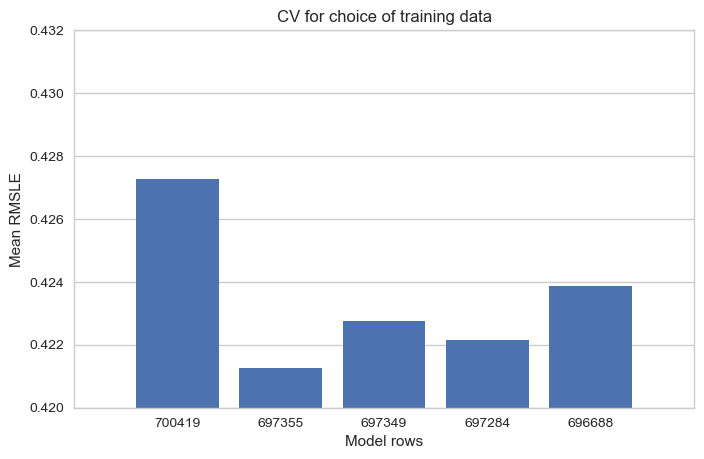

In [244]:

plt.bar(list(range(1, len(scores_all)+1)), [np.nanmean(i) for i in scores_all])
plt.xlim(0, len(scores_all)+1)
plt.ylim(0.420, 0.432)
plt.gca().xaxis.grid(False)


plt.xticks(np.arange(len(scores_all))+1, ['700419', '697355', '697349', '697284', '696688'])
plt.ylabel("Mean RMSLE")
plt.xlabel("Model rows")
plt.title("CV for choice of training data")
plt.show()



### Final selection: data with 697284 rows
(on repeated runs, other candidates might have given better results)

# Final formula and variables

In [245]:
fmla = 'np.log(I(dur+1)) ~ C(is_hol)\
+ C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + + C(dow):scale(I(hr**4))\
+ C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1)))\
+ scale(day_snowdepth) + scale(hr_temp)'
fmla

'np.log(I(dur+1)) ~ C(is_hol)+ C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + + C(dow):scale(I(hr**4))+ C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1)))+ scale(day_snowdepth) + scale(hr_temp)'

In [246]:
variables = ['log(duration + 1) ~ \n', 'C(day of week):(4th degree polynomial of hr)',\
             'C(airport pickup/dropoff)', 'modified cluster speed', 'log(OSRM total_time)',\
             'daily snow depth', 'hourly temperature']
print(variables[0] + ' + '.join(variables[1:]))

log(duration + 1) ~ 
C(day of week):(4th degree polynomial of hr) + C(airport pickup/dropoff) + modified cluster speed + log(OSRM total_time) + daily snow depth + hourly temperature


# Data used for training
#### (n = 697284)

In [247]:
df_train = pd.read_csv('../_data/pres_697284_final.csv')
df_train.head()

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,avg_spd,dur
0,0.0,False,0.0,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,24.786272,1454.0
1,0.0,False,0.0,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,26.462172,1409.0
2,0.0,False,0.0,430,Saturday,23,38,63,25.137761,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,30.890731,1081.0
3,0.0,False,0.0,430,Saturday,23,35,55,11.904820,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,12.271050,800.0
4,0.0,False,0.0,430,Saturday,23,14,79,13.197395,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,10.808758,1151.0


In [248]:
df_train.shape

(697284, 32)

# Basic regression results
* Choice of hr degree to be explained below

In [249]:
fmla = 'np.log(I(dur+1)) ~ \
C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(dow):scale(I(hr**4))\
+ C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1)))\
+ scale(day_snowdepth) + scale(hr_temp)'

In [250]:
fmla

'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(dow):scale(I(hr**4))+ C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1)))+ scale(day_snowdepth) + scale(hr_temp)'

#### Filter conditions:
* `total_dist == 0`
  * Did not move
  * Model separately with mean duration of subset
* `(total_dist <= 50) & (dur >= 300)`
  * Very slow for long amount of time
* `(avg_spd > 100) & (dur <= 20)`
  * Very fast for short amount of time

In [251]:
df_orig = pd.read_csv('../_data/pres_700419_extreme.csv')
df_orig.head()

,didnt_move,is_hol,blizz,m_d,dow,hr,wkhr,p_clust,d_clust,clust_spd,L2,pas_cnt,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,avg_spd,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,dur
0,0.0,False,0,430,Saturday,23,143,19,59,22.972353,0.069424,1,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,24.786272,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1454
1,0.0,False,0,430,Saturday,23,143,11,0,28.539090,0.057791,1,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,26.462172,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1409
2,0.0,False,0,430,Saturday,23,143,38,63,25.137761,0.066698,2,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,30.890731,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1081
3,0.0,False,0,430,Saturday,23,143,35,55,11.904820,0.018223,1,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,12.271050,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,800
4,0.0,False,0,430,Saturday,23,143,14,79,13.197395,0.027198,1,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,10.808758,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,1151


In [252]:
df_bbbbb.shape

(700419, 34)

In [253]:
df_orig.shape

(700419, 35)

In [254]:
def is_extreme(df):
    return (   (df['total_dist'] == 0)
             | (   (df['total_dist'] <= 50.0)
                 & (df['dur'] >= 300)
               )
             | (   (df['avg_spd'] > 100.0)
                 & (df['dur'] <= 20)
               )
           )

In [255]:
df_okay = df_orig.loc[~(is_extreme(df_orig))].copy()
df_okay.shape

(697284, 35)

In [256]:
mod_orig = sm.OLS.from_formula(fmla, data=df_orig)
res_orig = mod_orig.fit()

In [257]:
res_orig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(I(dur + 1))   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                 2.955e+04
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        18:11:03   Log-Likelihood:            -4.4489e+05
No. Observations:              700419   AIC:                         8.899e+05
Df Residuals:                  700376   BIC:                         8.904e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.4877      0.001   4682.602      0.000       6.485       6.490
C(is_hol)[T.True]                      -0.1200      0.004    -30.460      0.000      -0.128      -0.112
C(dow)[T.Monday]                       -0.0916      0.002    -43.567      0.000      -0.096      -0.087
C(dow)[T.Saturday]                     -0.0974      0.002    -49.516      0.000      -0.101      -0.094
C(dow)[T.Sunday]                       -0.1962      0.002    -93.966      0.000      -0.200      -0.192
C(dow)[T.Thursday]                      0.0078      0.002      3.906      0.000       0.004       0.012
C(dow)[T.Tuesday]                      -0.0282      0.002    -13.753      0.000      -0.032      -0.024
C(dow)[T.Wednesday]                    -0.0112      0.002     -5.535      0.000      -0.015      -0.007
C(p_LGA)[T.True]                        0.0800      0.004     21.150      0.000       0.073       0.087
C(d_JFK)[T.True]                        0.1243      0.008     16.302      0.000       0.109       0.139
C(d_LGA)[T.True]                       -0.0064      0.006     -1.151      0.250      -0.017       0.005
C(dow)[Friday]:scale(hr)               -0.6336      0.025    -25.327      0.000      -0.683      -0.585
C(dow)[Monday]:scale(hr)               -0.3895      0.032    -12.332      0.000      -0.451      -0.328
C(dow)[Saturday]:scale(hr)             -0.7947      0.024    -33.102      0.000      -0.842      -0.748
C(dow)[Sunday]:scale(hr)               -0.8266      0.025    -33.161      0.000      -0.875      -0.778
C(dow)[Thursday]:scale(hr)             -0.5986      0.028    -21.330      0.000      -0.654      -0.544
C(dow)[Tuesday]:scale(hr)              -0.5648      0.031    -18.295      0.000      -0.625      -0.504
C(dow)[Wednesday]:scale(hr)            -0.7010      0.029    -23.796      0.000      -0.759      -0.643
C(dow)[Friday]:scale(I(hr ** 2))        4.5092      0.114     39.502      0.000       4.286       4.733
C(dow)[Monday]:scale(I(hr ** 2))        3.9267      0.140     27.956      0.000       3.651       4.202
C(dow)[Saturday]:scale(I(hr ** 2))      3.2433      0.109     29.795      0.000       3.030       3.457
C(dow)[Sunday]:scale(I(hr ** 2))        3.0239      0.115     26.304      0.000       2.799       3.249
C(dow)[Thursday]:scale(I(hr ** 2))      5.0286      0.126     39.937      0.000       4.782       5.275
C(dow)[Tuesday]:scale(I(hr ** 2))       5.1131      0.136     37.508      0.000       4.846       5.380
C(dow)[Wednesday]:scale(I(hr ** 2))     5.5904      0.131     42.587      0.000       5.333       5.848
C(dow)[Friday]:scale(I(hr ** 3))       -7.0954      0.168    -42.183      0.000      -7.425      -6.766
C(dow)[Monday]:scale(I(hr ** 3))       -6.5805      0.206    -31.93

In [258]:
mod_okay = sm.OLS.from_formula(fmla, data=df_okay)
res_okay = mod_okay.fit()

In [259]:
res_okay.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(I(dur + 1))   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 4.501e+04
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        18:12:03   Log-Likelihood:            -3.2994e+05
No. Observations:              697284   AIC:                         6.600e+05
Df Residuals:                  697241   BIC:                         6.605e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.4976      0.001   5501.737      0.000       6.495       6.500
C(is_hol)[T.True]                      -0.1267      0.003    -37.742      0.000      -0.133      -0.120
C(dow)[T.Monday]                       -0.0903      0.002    -50.383      0.000      -0.094      -0.087
C(dow)[T.Saturday]                     -0.1050      0.002    -62.617      0.000      -0.108      -0.102
C(dow)[T.Sunday]                       -0.2047      0.002   -114.996      0.000      -0.208      -0.201
C(dow)[T.Thursday]                      0.0079      0.002      4.639      0.000       0.005       0.011
C(dow)[T.Tuesday]                      -0.0272      0.002    -15.533      0.000      -0.031      -0.024
C(dow)[T.Wednesday]                    -0.0105      0.002     -6.128      0.000      -0.014      -0.007
C(p_LGA)[T.True]                        0.0140      0.003      4.347      0.000       0.008       0.020
C(d_JFK)[T.True]                        0.0911      0.007     13.896      0.000       0.078       0.104
C(d_LGA)[T.True]                       -0.0874      0.005    -18.230      0.000      -0.097      -0.078
C(dow)[Friday]:scale(hr)               -0.6060      0.021    -28.413      0.000      -0.648      -0.564
C(dow)[Monday]:scale(hr)               -0.3611      0.027    -13.408      0.000      -0.414      -0.308
C(dow)[Saturday]:scale(hr)             -0.7829      0.020    -38.247      0.000      -0.823      -0.743
C(dow)[Sunday]:scale(hr)               -0.8360      0.021    -39.336      0.000      -0.878      -0.794
C(dow)[Thursday]:scale(hr)             -0.5754      0.024    -24.057      0.000      -0.622      -0.529
C(dow)[Tuesday]:scale(hr)              -0.5422      0.026    -20.611      0.000      -0.594      -0.491
C(dow)[Wednesday]:scale(hr)            -0.6703      0.025    -26.694      0.000      -0.720      -0.621
C(dow)[Friday]:scale(I(hr ** 2))        4.5408      0.097     46.665      0.000       4.350       4.731
C(dow)[Monday]:scale(I(hr ** 2))        3.9108      0.120     32.652      0.000       3.676       4.146
C(dow)[Saturday]:scale(I(hr ** 2))      3.3241      0.093     35.817      0.000       3.142       3.506
C(dow)[Sunday]:scale(I(hr ** 2))        3.1852      0.098     32.499      0.000       2.993       3.377
C(dow)[Thursday]:scale(I(hr ** 2))      5.0749      0.107     47.286      0.000       4.865       5.285
C(dow)[Tuesday]:scale(I(hr ** 2))       5.1481      0.116     44.309      0.000       4.920       5.376
C(dow)[Wednesday]:scale(I(hr ** 2))     5.5933      0.112     49.988      0.000       5.374       5.813
C(dow)[Friday]:scale(I(hr ** 3))       -7.1923      0.143    -50.164      0.000      -7.473      -6.911
C(dow)[Monday]:scale(I(hr ** 3))       -6.5883      0.176    -37.49

### Regression plots (`total_time`) pre-filter

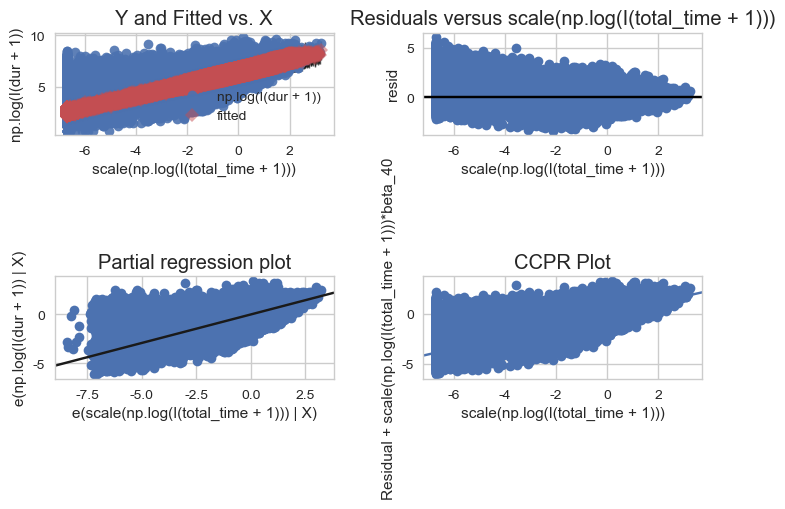

In [260]:
sm.graphics.plot_regress_exog(res_orig, 'scale(np.log(I(total_time + 1)))')
plt.suptitle("")
plt.show()

### Regression plots (`total_time`) post-filter

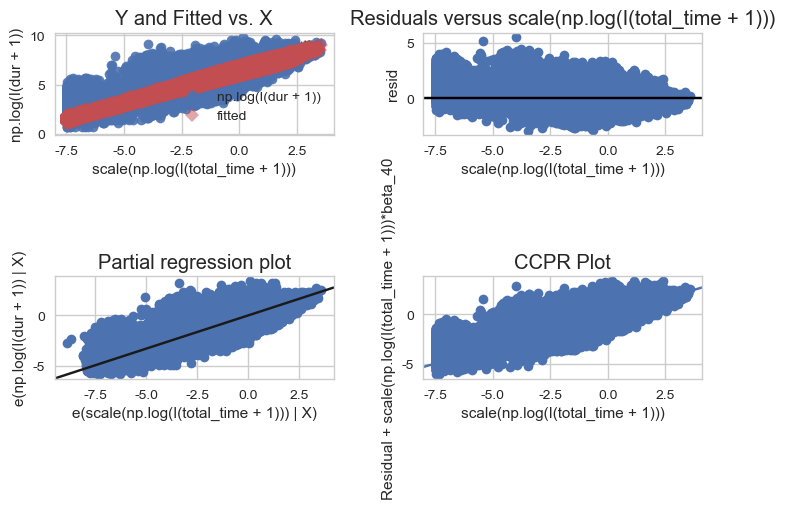

In [261]:
sm.graphics.plot_regress_exog(res_okay, 'scale(np.log(I(total_time + 1)))')
plt.suptitle("")
plt.show()

# Attempt at regularization
### * Grid search with (`hr` degrees, `alpha` for LASSO constraint)

#### * Helper functions

In [263]:
df_train.head(2)

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,avg_spd,dur
0,0.0,False,0.0,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,24.786272,1454.0
1,0.0,False,0.0,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,26.462172,1409.0


In [264]:
def get_date_rowrange(df, d1, d2):
    top = df[(df['m_d'] >= d1)
                   &(df['m_d'] < d2)].iloc[0, :].name
    bot = df[(df['m_d'] >= d1)
                   &(df['m_d'] < d2)].iloc[-1, :].name
    return top, bot

print(get_date_rowrange(df_train, 115, 211))

(476375, 622291)


In [266]:
df_train[(df_train['m_d'] >= 115)
                   &(df_train['m_d'] < 211)].head(1)

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,avg_spd,dur
476375,0.0,False,0.0,210,Wednesday,23,13,10,27.847165,False,False,False,False,-74.010849,40.708778,-73.977829,40.788803,11097.6,980.6,39,31,0.01,0.0,0.0,0.0,0.52,-8.9,5.6,0.0,0.0,29.076681,1374.0


In [267]:
df_train[(df_train['m_d'] >= 115)
                   &(df_train['m_d'] < 211)].tail(1)

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,avg_spd,dur
622291,0.0,False,0.0,115,Friday,0,35,56,14.064045,False,False,False,False,-73.981995,40.740444,-74.0047,40.741806,2787.8,374.0,51,34,0.0,0.0,0.0,2.8,0.54,-5.6,5.6,0.0,0.0,12.5451,800.0


In [268]:
# Number of rows in row range for dates
get_date_rowrange(df_train, 401, 501)[1] - get_date_rowrange(df_train, 401, 501)[0] + 1

179807

### * Custom train_test splitter (based on reference date)
####   Used because of date difference between train and test data

In [269]:
import random


def train_test_date_samples(X, y, train_size=None,\
                            test_size=None,\
                            train_range=(101, 401),
                            test_range=(401, 501)):
    
    train_start, train_end = get_date_rowrange(X, *train_range)
    test_start, test_end = get_date_rowrange(X, *test_range)

    train_cnt = train_end - train_start + 1
    test_cnt = test_end - test_start + 1
    
    if not train_size or train_size > train_cnt:
        train_size = train_cnt
    if not test_size or test_size > test_cnt:
        test_size = test_cnt
    
    train_indices = random.sample(range(train_start, train_end+1),\
                                  k=train_size)
    test_indices = random.sample(range(test_start, test_end+1),\
                                  k=test_size)
    
    print("test_size: {}\ntrain_size: {}".format(test_size, train_size))
    print("test / (train + test) = {}".format(test_size / (train_size + test_size)))
        
    return X.loc[train_indices, :], X.loc[test_indices, :],\
           y.loc[train_indices], y.loc[test_indices]


X, y = df_train.iloc[:, :-1], df_train.iloc[:, -1]
    
a, b, c, d = train_test_date_samples(X, y)

a.shape, b.shape, c.shape, d.shape

test_size: 179807
train_size: 517477
test / (train + test) = 0.257867669414471


((517477, 31), (179807, 31), (517477,), (179807,))

In [270]:
def poly_string(deg, scale_=True):    
    var_ = 'hr'
    poly_sum = 'C(dow):scale({})'.format(var_) if scale_ else 'C(dow):{}'.format(var_)
    for pwr in range(2, deg+1):
        nth_deg = ' + C(dow):scale(I({}**{}))'.format(var_, pwr) if scale_\
                  else ' + C(dow):I({}**{})'.format(var_, pwr)
        poly_sum += nth_deg
    return poly_sum


def get_fmla(hr_deg):
    return 'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + '\
         + poly_string(hr_deg)\
         + ' + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd)'\
         + ' + scale(np.log(I(total_time+1))) + scale(day_snowdepth)'\
         + ' + scale(hr_temp)'

print(poly_string(6, True))
print(poly_string(4, False))
get_fmla(7)

C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(dow):scale(I(hr**4)) + C(dow):scale(I(hr**5)) + C(dow):scale(I(hr**6))
C(dow):hr + C(dow):I(hr**2) + C(dow):I(hr**3) + C(dow):I(hr**4)


'np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(dow):scale(I(hr**4)) + C(dow):scale(I(hr**5)) + C(dow):scale(I(hr**6)) + C(dow):scale(I(hr**7)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)'

### Cross-validator given degree and alpha

Make sure `dur` column is at right end of DF

In [271]:
dur_copy = df_train['dur'].copy()
del df_train['dur']
df_train['dur'] = dur_copy
df_train.head()

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,avg_spd,dur
0,0.0,False,0.0,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,24.786272,1454.0
1,0.0,False,0.0,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,26.462172,1409.0
2,0.0,False,0.0,430,Saturday,23,38,63,25.137761,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,30.890731,1081.0
3,0.0,False,0.0,430,Saturday,23,35,55,11.904820,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,12.271050,800.0
4,0.0,False,0.0,430,Saturday,23,14,79,13.197395,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,10.808758,1151.0


In [272]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

from datetime import datetime

def run_cv_reg(hr_deg, df, alpha, n=3):
    t0 = datetime.now()
    print(t0)

    fmla = get_fmla(hr_deg)
    df = df
    scores = np.zeros(n)

    print("Train has {} rows".format(df.shape[0]))
    print("Test has {} rows".format(df.shape[0]))
    print("formula = {}\n".format(fmla))

    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_date_samples(df.iloc[:, :-1], df.iloc[:, -1],\
                                                                    train_size=100000,\
                                                                    test_size=50000,\
                                                                    train_range=(101, 401),\
                                                                    test_range=(401, 501))
        df_train__ = pd.concat([X_train, y_train], axis=1)

        print("------trial {}------".format(i+1))
        model_train = sm.OLS.from_formula(fmla, data=df_train__)
        res_train = model_train.fit_regularized(alpha=alpha, L1_wt=1.0)

        y_pred = res_train.predict(X_test)
        y_pred = np.exp(y_pred)

        try:
            scores[i] = mean_squared_log_error(y_test, y_pred)
            print(pd.concat([y_test, y_pred], axis=1).head(5))
            print(np.sqrt(scores))
        except:
            print("except")
            print(df.shape)
            print(y_test[y_test<=0].shape)
            print(y_pred[y_pred<=0].shape)
            break

    scores = np.sqrt(scores)
    print(scores)

    t1 = datetime.now()
    print(t1)
    print(t1 - t0)
    print()
    print()
    return scores

In [273]:
df_train.shape

(697284, 32)

* degree range

In [274]:
deg_range = list(range(3, 10))
deg_range

[3, 4, 5, 6, 7, 8, 9]

* alpha range

In [275]:
alpha_range = np.logspace(-3, 1, 5)
alpha_range

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01])

In [276]:
df_train.shape

(697284, 32)

# warning: 40분 정도 걸림

In [ ]:
n = 5
S = dict()

for deg in deg_range:
    scoreses = dict()
    for alpha in alpha_range:
        try:
            print('='*25 + 'RUNNING DEGREE {}, ALPHA {}'.format(deg, alpha) + '='*25)
            scores = run_cv_reg(deg, df_train, alpha, n)
            scoreses[alpha] = scores
        except:
            print('exception')
            continue
    S[deg] = scoreses


=========================RUNNING DEGREE 3, ALPHA 0.001=========================
2017-10-25 18:15:42.260461
Train has 697284 rows
Test has 697284 rows
formula = np.log(I(dur+1)) ~ C(is_hol) + C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1))) + scale(day_snowdepth) + scale(hr_temp)

test_size: 50000
train_size: 100000
test / (train + test) = 0.3333333333333333
------trial 1------
          dur            0
106601  729.0   746.218444
161798  870.0   512.497821
129931  319.0   484.268739
64694   999.0  1114.112729
139580  554.0   494.146845
[ 0.40647819  0.          0.          0.          0.        ]
test_size: 50000
train_size: 100000
test / (train + test) = 0.3333333333333333
------trial 2------
           dur            0
148692   721.0   630.282162
159057   916.0   911.924969
177753  1149.0  1333.202585
68475    927.0   602.986298
471      833.0  1122.681917
[ 0.40647819  0.4

In [24]:
S1 = S.copy()

for deg in S1.keys():
    for alpha in S1[deg].keys():
        S1[deg][alpha] = np.mean(S1[deg][alpha])

In [25]:
S1

{3: {0.001: 0.40843321338614674,
  0.01: 0.43285799341699766,
  0.10000000000000001: 0.46847038932587548,
  1.0: 1.2920014282816854,
  10.0: 5.8366493614139401},
 4: {0.001: 0.40738437928954685,
  0.01: 0.43132050571937841,
  0.10000000000000001: 0.46907706958977818,
  1.0: 1.2919976449748218,
  10.0: 5.8373796161794562},
 5: {0.001: 0.40614991938610878,
  0.01: 0.43004564752830304,
  0.10000000000000001: 0.47040960386936115,
  1.0: 1.2906293173530714,
  10.0: 5.8376802336640932},
 6: {0.001: 0.40634596851157473,
  0.01: 0.43237093414847305,
  0.10000000000000001: 0.46916774069362888,
  1.0: 1.287979696763192,
  10.0: 5.8337225454762125},
 7: {0.001: 0.40592299053397324,
  0.01: 0.43008514872526593,
  0.10000000000000001: 0.46908201985636255,
  1.0: 1.291104063480085,
  10.0: 5.8369006104642729},
 8: {0.001: 0.40578827129200334,
  0.01: 0.43046548160358056,
  0.10000000000000001: 0.47006232040232981,
  1.0: 1.2912664822132165,
  10.0: 5.8372191830741658},
 9: {0.001: 0.4059267232090664

In [26]:
df_res = pd.DataFrame(S1)
df_res

,3,4,5,6,7,8,9
0.001,0.408433,0.407384,0.406150,0.406346,0.405923,0.405788,0.405927
0.010,0.432858,0.431321,0.430046,0.432371,0.430085,0.430465,0.431199
0.100,0.468470,0.469077,0.470410,0.469168,0.469082,0.470062,0.469741
1.000,1.292001,1.291998,1.290629,1.287980,1.291104,1.291266,1.291637
10.000,5.836649,5.837380,5.837680,5.833723,5.836901,5.837219,5.837627


In [27]:
df_res = pd.read_csv('../_data/pres_gridsearch.csv', index_col='alpha')
df_res

,3,4,5,6,7,8,9
alpha,,,,,,,
0.001,0.431080,0.430184,0.428958,0.428546,0.429374,0.427043,0.426528
0.010,0.453508,0.451510,0.452782,0.452340,0.453141,0.451769,0.450582
0.100,0.495007,0.496949,0.496349,0.498243,0.496510,0.497324,0.497304
1.000,1.298573,1.298837,1.297834,1.297368,1.300591,1.300550,1.297289
10.000,5.834343,5.831790,5.833884,5.833047,5.833396,5.832592,5.835387


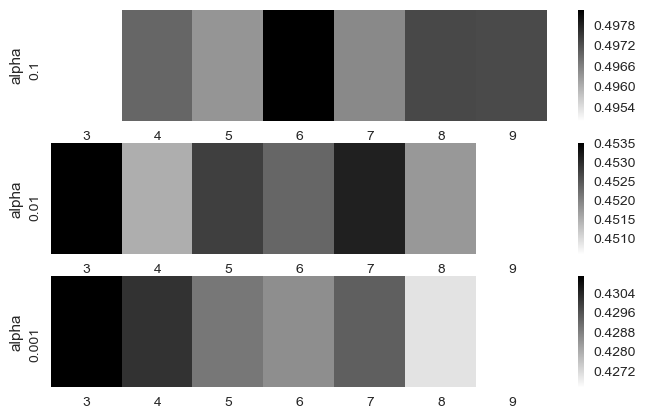

In [28]:
plt.subplot(311)
plt.ylabel = 'alpha'
plt.xlabel = 'degree of hr'
sns.heatmap(df_res.iloc[2:3, :], cmap='binary')

plt.subplot(312)
plt.ylabel = 'alpha'
plt.xlabel = 'degree of hr'
sns.heatmap(df_res.iloc[1:2, :], cmap='binary')

plt.subplot(313)
plt.ylabel = 'alpha'
plt.xlabel = 'degree of hr'
sns.heatmap(df_res.iloc[0:1, :], cmap='binary')

plt.show()

### * No regularization performed.

# Final formula and variables

In [ ]:
fmla = 'np.log(I(dur+1)) ~ C(is_hol)\
+ C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + + C(dow):scale(I(hr**4))\
+ C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1)))\
+ scale(day_snowdepth) + scale(hr_temp)'
fmla

In [4]:
variables = ['log(duration + 1) ~ \n', 'C(day of week):(4th degree polynomial of hr)',\
             'C(airport pickup/dropoff)', 'modified cluster speed', 'log(OSRM total_time)',\
             'daily snow depth', 'hourly temperature']
print(variables[0] + ' + '.join(variables[1:]))

log(duration + 1) ~ 
C(day of week):(4th degree polynomial of hr) + C(airport pickup/dropoff) + modified cluster speed + log(OSRM total_time) + daily snow depth + hourly temperature


# Final prediction

In [87]:
df_test = pd.read_csv('../_data/pres_test_recent.csv')
df_test.head()

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip
0,0.0,False,0.0,630,Thursday,23,58,45,17.343755,False,False,False,False,-73.998291,40.722618,-73.971779,40.762470,5280.3,623.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0
1,0.0,False,0.0,630,Thursday,23,22,6,19.795471,False,False,False,False,-73.955109,40.689564,-73.978203,40.685802,2573.5,219.3,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0
2,0.0,False,0.0,630,Thursday,23,36,6,20.224880,False,False,False,False,-73.978416,40.791576,-73.973160,40.675968,15048.8,1300.0,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0
3,0.0,False,0.0,630,Thursday,23,3,31,40.972632,False,True,False,False,-73.873093,40.774097,-73.926704,40.856739,16818.3,1029.1,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0
4,0.0,False,0.0,630,Thursday,23,53,56,15.825632,False,False,False,False,-73.979416,40.755211,-74.003548,40.738224,3536.7,434.5,85,67,0.0,0.0,0.0,24.4,0.6,16.1,0.0,0.0,0.0


In [80]:
df_train2 = pd.read_csv('../_data/pres_697284_final.csv')
df_train2.head()

,didnt_move,is_hol,blizz,m_d,dow,hr,p_clust,d_clust,clust_spd,p_JFK,p_LGA,d_JFK,d_LGA,p_lng,p_lat,d_lng,d_lat,total_dist,total_time,day_max_temp,day_min_temp,day_rainfall,day_snowfall,day_snowdepth,hr_temp,hr_humid,hr_dewpt,hr_windspeed,hr_gustspeed,hr_precip,avg_spd,dur
0,0.0,False,0.0,430,Saturday,23,19,59,22.972353,False,False,False,False,-73.987793,40.724792,-73.975616,40.656445,10010.9,861.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,24.786272,1454.0
1,0.0,False,0.0,430,Saturday,23,11,0,28.539090,False,False,False,False,-73.957596,40.717770,-73.951424,40.775230,10357.0,786.3,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,26.462172,1409.0
2,0.0,False,0.0,430,Saturday,23,38,63,25.137761,False,False,False,False,-74.000954,40.742031,-73.947708,40.782200,9275.8,703.9,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,30.890731,1081.0
3,0.0,False,0.0,430,Saturday,23,35,55,11.904820,False,False,False,False,-73.985733,40.738258,-73.993179,40.754890,2726.9,298.0,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,12.271050,800.0
4,0.0,False,0.0,430,Saturday,23,14,79,13.197395,False,False,False,False,-74.006615,40.740650,-73.985619,40.723362,3455.8,458.2,65,46,0.0,0.0,0.0,10.6,0.56,2.2,13.0,0.0,0.0,10.808758,1151.0


In [83]:
fmla = 'np.log(I(dur+1)) ~ C(is_hol)\
+ C(dow) + C(dow):scale(hr) + C(dow):scale(I(hr**2)) + C(dow):scale(I(hr**3)) + + C(dow):scale(I(hr**4))\
+ C(p_LGA) + C(d_JFK) + C(d_LGA) + scale(clust_spd) + scale(np.log(I(total_time+1)))\
+ scale(day_snowdepth) + scale(hr_temp)'

In [84]:
mod = sm.OLS.from_formula(fmla, data=df_train2)
res = mod.fit()

In [85]:
%%time
res.summary()

Wall time: 153 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(I(dur + 1))   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                 4.501e+04
Date:                Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:10:08   Log-Likelihood:            -3.2994e+05
No. Observations:              697284   AIC:                         6.600e+05
Df Residuals:                  697241   BIC:                         6.605e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               6.4976      0.001   5501.737      0.000       6.495       6.500
C(is_hol)[T.True]                      -0.1267      0.003    -37.742      0.000      -0.133      -0.120
C(dow)[T.Monday]                       -0.0903      0.002    -50.383      0.000      -0.094      -0.087
C(dow)[T.Saturday]                     -0.1050      0.002    -62.617      0.000      -0.108      -0.102
C(dow)[T.Sunday]                       -0.2047      0.002   -114.996      0.000      -0.208      -0.201
C(dow)[T.Thursday]                      0.0079      0.002      4.639      0.000       0.005       0.011
C(dow)[T.Tuesday]                      -0.0272      0.002    -15.533      0.000      -0.031      -0.024
C(dow)[T.Wednesday]                    -0.0105      0.002     -6.128      0.000      -0.014      -0.007
C(p_LGA)[T.True]                        0.0140      0.003      4.347      0.000       0.008       0.020
C(d_JFK)[T.True]                        0.0911      0.007     13.896      0.000       0.078       0.104
C(d_LGA)[T.True]                       -0.0874      0.005    -18.230      0.000      -0.097      -0.078
C(dow)[Friday]:scale(hr)               -0.6060      0.021    -28.413      0.000      -0.648      -0.564
C(dow)[Monday]:scale(hr)               -0.3611      0.027    -13.408      0.000      -0.414      -0.308
C(dow)[Saturday]:scale(hr)             -0.7829      0.020    -38.247      0.000      -0.823      -0.743
C(dow)[Sunday]:scale(hr)               -0.8360      0.021    -39.336      0.000      -0.878      -0.794
C(dow)[Thursday]:scale(hr)             -0.5754      0.024    -24.057      0.000      -0.622      -0.529
C(dow)[Tuesday]:scale(hr)              -0.5422      0.026    -20.611      0.000      -0.594      -0.491
C(dow)[Wednesday]:scale(hr)            -0.6703      0.025    -26.694      0.000      -0.720      -0.621
C(dow)[Friday]:scale(I(hr ** 2))        4.5408      0.097     46.665      0.000       4.350       4.731
C(dow)[Monday]:scale(I(hr ** 2))        3.9108      0.120     32.652      0.000       3.676       4.146
C(dow)[Saturday]:scale(I(hr ** 2))      3.3241      0.093     35.817      0.000       3.142       3.506
C(dow)[Sunday]:scale(I(hr ** 2))        3.1852      0.098     32.499      0.000       2.993       3.377
C(dow)[Thursday]:scale(I(hr ** 2))      5.0749      0.107     47.286      0.000       4.865       5.285
C(dow)[Tuesday]:scale(I(hr ** 2))       5.1481      0.116     44.309      0.000       4.920       5.376
C(dow)[Wednesday]:scale(I(hr ** 2))     5.5933      0.112     49.988      0.000       5.374       5.813
C(dow)[Friday]:scale(I(hr ** 3))       -7.1923      0.143    -50.164      0.000      -7.473      -6.911
C(dow)[Monday]:scale(I(hr ** 3))       -6.5883      0.176    -37.49

In [88]:
test_pred_log = res.predict(df_test)
test_pred = np.exp(test_pred_log)
test_pred.head()

0    1132.648731
1     450.522930
2    2100.667327
3    1504.903759
4     837.215176
dtype: float64

In [89]:
test_pred.loc[393:394]

393    2016.411595
394       4.251729
dtype: float64

In [90]:
df_test.loc[:, 'dur'] = test_pred
avg_zero = 503.51274886482713
df_test.loc[df_test['total_dist'] == 0.0, 'dur'] = avg_zero
test_pred = df_test.loc[:, 'dur']

test_pred.loc[393:394]

393    2016.411595
394     503.512749
Name: dur, dtype: float64

In [91]:
test_pred.head()

0    1132.648731
1     450.522930
2    2100.667327
3    1504.903759
4     837.215176
Name: dur, dtype: float64

### Constructing final answer file

In [15]:
np.logspace(-3, 2, 6)

array([  1.00000000e-03,   1.00000000e-02,   1.00000000e-01,
         1.00000000e+00,   1.00000000e+01,   1.00000000e+02])

In [20]:
df_test_orig = pd.read_csv('../_data/pres___test.csv')
df_test_orig.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2332349,2,6/30/16 23:59,5,-73.998291,40.722618,-73.971779,40.762470,N
1,id2013516,1,6/30/16 23:59,2,-73.955109,40.689564,-73.978203,40.685802,N
2,id3719493,2,6/30/16 23:59,1,-73.978416,40.791576,-73.973160,40.675968,N
3,id0376262,1,6/30/16 23:59,2,-73.873093,40.774097,-73.926704,40.856739,N
4,id2105228,1,6/30/16 23:58,1,-73.979416,40.755211,-74.003548,40.738224,N


In [100]:
df_test_orig.shape

(346797, 9)

In [101]:
test_pred.shape

(346797,)

In [21]:
df_final = pd.concat([df_test_orig['id'], test_pred], axis=1, names=['id', 'trip_duration'])
df_final.columns = ['id', 'trip_duration']
df_final.loc[394:396, :]

,id,trip_duration
394,id2447155,503.512749
395,id1398839,598.186333
396,id1845621,605.193967


In [22]:
df_final.head()

,id,trip_duration
0,id2332349,1132.648731
1,id2013516,450.522930
2,id3719493,2100.667327
3,id0376262,1504.903759
4,id2105228,837.215176


# Assessment by RMSLE

In [46]:
S1[3].keys()

dict_keys([0.001, 0.01, 0.10000000000000001, 1.0, 10.0])

In [47]:
for deg in S1.keys():
    for alpha in S1[deg].keys():
        S1[deg][alpha] = np.mean(S1[deg][alpha])


In [48]:
S1

{3: {0.001: 0.43107966860982677,
  0.01: 0.45350822260954737,
  0.10000000000000001: 0.49500721708551881,
  1.0: 1.298573155600167,
  10.0: 5.8343432609680566},
 4: {0.001: 0.43018388079856973,
  0.01: 0.45151007823385819,
  0.10000000000000001: 0.49694943848541523,
  1.0: 1.298837095908032,
  10.0: 5.8317901478567267},
 5: {0.001: 0.4289577872071561,
  0.01: 0.45278159300942827,
  0.10000000000000001: 0.49634936650548855,
  1.0: 1.2978344490771057,
  10.0: 5.8338843378925462},
 6: {0.001: 0.42854579965315426,
  0.01: 0.45234035158963276,
  0.10000000000000001: 0.4982434771194032,
  1.0: 1.2973681528918455,
  10.0: 5.8330474517760251},
 7: {0.001: 0.42937408625174633,
  0.01: 0.45314065621040339,
  0.10000000000000001: 0.49651019493435616,
  1.0: 1.3005907425694514,
  10.0: 5.8333964054576803},
 8: {0.001: 0.42704283865269943,
  0.01: 0.45176921680189974,
  0.10000000000000001: 0.49732425002855196,
  1.0: 1.3005499574763852,
  10.0: 5.8325918113389363},
 9: {0.001: 0.42652754108221175,

In [17]:
df_ans = pd.read_csv('../_data/pres_test_answer_nyc_taxi.csv',\
                    usecols=['id', 'trip_duration'])

df_ans.head()

C:\Users\jchoi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,trip_duration
0,id2332349,1442.0
1,id2013516,754.0
2,id3719493,2609.0
3,id0376262,2546.0
4,id2105228,656.0


In [23]:
from sklearn.metrics import mean_squared_log_error

y_ans = df_ans.loc[0:346796, 'trip_duration']
y_pred = df_final['trip_duration']

try:
    score = np.sqrt(mean_squared_log_error(y_ans, y_pred))
except:
    print("except")
    print(y_test[y_test<=0].shape)
    print(y_pred[y_pred<=0].shape)


print("Final score (RMSLE): {}".format(score))

Final score (RMSLE): 0.4832057518771819


# Partial comparison

In [126]:
df_comp = pd.concat([y_ans, y_pred], axis=1)
df_comp.head(10)

,trip_duration,trip_duration
0,1442.0,1132.648731
1,754.0,450.522930
2,2609.0,2100.667327
3,2546.0,1504.903759
4,656.0,837.215176
5,712.0,637.322862
6,621.0,452.509077
7,849.0,752.324729
8,472.0,493.986523
9,463.0,451.355365


끝